In [61]:
# pip install --upgrade scikit-learn xgboost scikit-optimize

### 检查一下 downsample 的影响

In [83]:
# Data Preparation and TF-IDF Model Training

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("merged_csv.csv")

print("="*70)
print("DATA PREPARATION FOR MODELING")
print("="*70)
print(f"Original total samples: {len(df)}")

# Downsample to 1,000 samples while maintaining class distribution
df_sampled = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 100), random_state=42)
).sample(frac=1, random_state=42).reset_index(drop=True)


df = df_sampled

print(f"Downsampled total samples: {len(df)}")
print(f"Features: subject, body")
print(f"Target: label (0=Legit, 1=Spam)")
print(f"Class distribution after sampling:\n{df['label'].value_counts()}")
print()

# Handle missing values - fill with empty strings
df['subject'] = df['subject'].fillna('')
df['body'] = df['body'].fillna('')

# Combine subject and body for complete text representation
df['combined_text'] = df['subject'] + ' ' + df['body']

X = df['combined_text']
y = df['label']

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")
print()

DATA PREPARATION FOR MODELING
Original total samples: 49860
Downsampled total samples: 200
Features: subject, body
Target: label (0=Legit, 1=Spam)
Class distribution after sampling:
label
0    100
1    100
Name: count, dtype: int64

Training samples: 160
Testing samples: 40
Training label distribution:
label
0    80
1    80
Name: count, dtype: int64
Testing label distribution:
label
0    20
1    20
Name: count, dtype: int64



In [84]:
# TF-IDF Vectorization

print("="*70)
print("TF-IDF VECTORIZATION")
print("="*70)

# Initialize TF-IDF Vectorizer
# - max_features: limit to top 5000 features to reduce dimensionality
# - ngram_range: use unigrams and bigrams
# - min_df: ignore terms that appear in less than 2 documents
# - max_df: ignore terms that appear in more than 95% of documents
# - sublinear_tf: apply sublinear tf scaling (replace tf with 1 + log(tf))

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Matrix Shape (Train): {X_train_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Test): {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print()

# Show top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Sample features: {list(feature_names[:20])}")
print()

TF-IDF VECTORIZATION
TF-IDF Matrix Shape (Train): (160, 5000)
TF-IDF Matrix Shape (Test): (40, 5000)
Vocabulary size: 5000

Sample features: ['00', '000', '000 000', '000 gorillas', '0000', '01', '01 anthrax', '01 blake', '01 brangelina', '01 campaign', '01 canada', '01 dnt', '01 hill', '01 jena6', '01 karadzic', '01 nota', '01 rockefeller', '01 sot', '01 unusual', '01 von']



In [85]:
# Model 1: Naive Bayes Classifier

print("="*70)
print("MODEL 1: MULTINOMIAL NAIVE BAYES")
print("="*70)

# Train Naive Bayes model
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test_tfidf)
y_pred_proba_nb = nb_model.predict_proba(X_test_tfidf)

# Evaluation
print("PERFORMANCE METRICS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_nb):.4f}")
print()

print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_nb, target_names=['Legit', 'Spam']))
print()

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("CONFUSION MATRIX:")
print(cm_nb)
print()

MODEL 1: MULTINOMIAL NAIVE BAYES
PERFORMANCE METRICS:
Accuracy: 0.7750
Precision: 1.0000
Recall: 0.5500
F1-Score: 0.7097

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Legit       0.69      1.00      0.82        20
        Spam       1.00      0.55      0.71        20

    accuracy                           0.78        40
   macro avg       0.84      0.78      0.76        40
weighted avg       0.84      0.78      0.76        40


CONFUSION MATRIX:
[[20  0]
 [ 9 11]]



In [86]:
# Model 2: Logistic Regression

print("="*70)
print("MODEL 2: LOGISTIC REGRESSION")
print("="*70)

# Train Logistic Regression model
# Use 'saga' solver which works well with l1 penalty for sparse data
lr_model = LogisticRegression(
    max_iter=1000,
    solver='saga',
    penalty='l2',
    C=1.0,
    random_state=42
)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)

# Evaluation
print("PERFORMANCE METRICS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print()

print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_lr, target_names=['Legit', 'Spam']))
print()

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("CONFUSION MATRIX:")
print(cm_lr)
print()

MODEL 2: LOGISTIC REGRESSION
PERFORMANCE METRICS:
Accuracy: 0.9000
Precision: 1.0000
Recall: 0.8000
F1-Score: 0.8889

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Legit       0.83      1.00      0.91        20
        Spam       1.00      0.80      0.89        20

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40


CONFUSION MATRIX:
[[20  0]
 [ 4 16]]



## data cleaning

In [87]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [88]:
# Load data
df = pd.read_csv("merged_csv.csv")

print("="*70)
print("DATA CLEANING PIPELINE WITH ABLATION STUDY")
print("="*70)
print(f"Original total samples: {len(df)}")

df_sampled = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 1000), random_state=42)
).sample(frac=1, random_state=42).reset_index(drop=True)


df = df_sampled

print(f"Downsampled total samples: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")
print()

# Handle missing values
df['subject'] = df['subject'].fillna('')
df['body'] = df['body'].fillna('')
df['full_text'] = df['subject'] + ' ' + df['body']

def train_and_evaluate(X_train, X_test, y_train, y_test, step_name):
    """Train Naive Bayes and return metrics"""
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2, max_df=0.95)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Train Naive Bayes
    model = MultinomialNB(alpha=0.1)
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    metrics = {
        'Step': step_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    return metrics, y_pred

# Split data
y = df['label']
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    df.index, y, test_size=0.2, random_state=42, stratify=y
)

DATA CLEANING PIPELINE WITH ABLATION STUDY
Original total samples: 49860
Downsampled total samples: 2000
Class distribution:
label
1    1000
0    1000
Name: count, dtype: int64



In [89]:
results = []

# ============================================================================
# STEP 0: Baseline - No Cleaning (Raw Text)
# ============================================================================
print("="*70)
print("STEP 0: BASELINE - RAW TEXT (NO CLEANING)")
print("="*70)

df['step0_text'] = df['full_text']

X_train_0 = df.loc[X_train_idx, 'step0_text']
X_test_0 = df.loc[X_test_idx, 'step0_text']

metrics_0, y_pred_0 = train_and_evaluate(X_train_0, X_test_0, y_train, y_test, "0. Baseline (Raw)")
results.append(metrics_0)

print(f"Accuracy: {metrics_0['Accuracy']:.4f}")
print(f"Precision: {metrics_0['Precision']:.4f}")
print(f"Recall: {metrics_0['Recall']:.4f}")
print(f"F1-Score: {metrics_0['F1-Score']:.4f}")
print()

STEP 0: BASELINE - RAW TEXT (NO CLEANING)
Accuracy: 0.9100
Precision: 0.9316
Recall: 0.8850
F1-Score: 0.9077



In [90]:
# ============================================================================
# STEP 1: Lowercase Conversion
# ============================================================================
print("="*70)
print("STEP 1: LOWERCASE CONVERSION")
print("="*70)

df['step1_text'] = df['full_text'].str.lower()

X_train_1 = df.loc[X_train_idx, 'step1_text']
X_test_1 = df.loc[X_test_idx, 'step1_text']

metrics_1, y_pred_1 = train_and_evaluate(X_train_1, X_test_1, y_train, y_test, "1. + Lowercase")
results.append(metrics_1)

print(f"Accuracy: {metrics_1['Accuracy']:.4f}")
print(f"Precision: {metrics_1['Precision']:.4f}")
print(f"Recall: {metrics_1['Recall']:.4f}")
print(f"F1-Score: {metrics_1['F1-Score']:.4f}")
print(f"Improvement from baseline: {(metrics_1['F1-Score'] - metrics_0['F1-Score']):.4f}")
print()

STEP 1: LOWERCASE CONVERSION
Accuracy: 0.9100
Precision: 0.9316
Recall: 0.8850
F1-Score: 0.9077
Improvement from baseline: 0.0000



In [91]:
# ============================================================================
# STEP 2: Remove Punctuation and Numbers
# ============================================================================
print("="*70)
print("STEP 2: REMOVE PUNCTUATION AND NUMBERS")
print("="*70)

def remove_punctuation_numbers(text):
    """Remove punctuation and numbers using regex"""
    if pd.isna(text):
        return ""
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['step2_text'] = df['full_text'].apply(remove_punctuation_numbers)

X_train_2 = df.loc[X_train_idx, 'step2_text']
X_test_2 = df.loc[X_test_idx, 'step2_text']

metrics_2, y_pred_2 = train_and_evaluate(X_train_2, X_test_2, y_train, y_test, "2. + Remove Punct/Numbers")
results.append(metrics_2)

print(f"Accuracy: {metrics_2['Accuracy']:.4f}")
print(f"Precision: {metrics_2['Precision']:.4f}")
print(f"Recall: {metrics_2['Recall']:.4f}")
print(f"F1-Score: {metrics_2['F1-Score']:.4f}")
print(f"Improvement from step 0: {(metrics_2['F1-Score'] - metrics_0['F1-Score']):.4f}")
print()

STEP 2: REMOVE PUNCTUATION AND NUMBERS
Accuracy: 0.9025
Precision: 0.9448
Recall: 0.8550
F1-Score: 0.8976
Improvement from step 0: -0.0101



In [92]:
# ============================================================================
# STEP 3: Tokenization
# ============================================================================
print("="*70)
print("STEP 3: TOKENIZATION")
print("="*70)

def tokenize_text(text):
    """Tokenize text into words"""
    if pd.isna(text) or text == "":
        return ""
    tokens = word_tokenize(str(text))
    return ' '.join(tokens)

df['step3_text'] = df['full_text'].apply(tokenize_text)

X_train_3 = df.loc[X_train_idx, 'step3_text']
X_test_3 = df.loc[X_test_idx, 'step3_text']

metrics_3, y_pred_3 = train_and_evaluate(X_train_3, X_test_3, y_train, y_test, "3. + Tokenization")
results.append(metrics_3)

print(f"Accuracy: {metrics_3['Accuracy']:.4f}")
print(f"Precision: {metrics_3['Precision']:.4f}")
print(f"Recall: {metrics_3['Recall']:.4f}")
print(f"F1-Score: {metrics_3['F1-Score']:.4f}")
print(f"Improvement from step 0: {(metrics_3['F1-Score'] - metrics_0['F1-Score']):.4f}")
print()

STEP 3: TOKENIZATION
Accuracy: 0.9150
Precision: 0.9368
Recall: 0.8900
F1-Score: 0.9128
Improvement from step 0: 0.0051



In [93]:
# ============================================================================
# STEP 4: Remove Stop Words
# ============================================================================
print("="*70)
print("STEP 4: REMOVE STOP WORDS")
print("="*70)

# Get English stop words
stop_words = set(stopwords.words('english'))
# Add custom stop words for emails
stop_words.update(['re', 'fwd', 'subject', 'email', 'com', 'www'])

def remove_stopwords(text):
    """Remove stop words from text"""
    if pd.isna(text) or text == "":
        return ""
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

df['step4_text'] = df['step3_text'].apply(remove_stopwords)

X_train_4 = df.loc[X_train_idx, 'step4_text']
X_test_4 = df.loc[X_test_idx, 'step4_text']

metrics_4, y_pred_4 = train_and_evaluate(X_train_4, X_test_4, y_train, y_test, "4. + Remove Stopwords")
results.append(metrics_4)

print(f"Accuracy: {metrics_4['Accuracy']:.4f}")
print(f"Precision: {metrics_4['Precision']:.4f}")
print(f"Recall: {metrics_4['Recall']:.4f}")
print(f"F1-Score: {metrics_4['F1-Score']:.4f}")
print(f"Improvement from step 3: {(metrics_4['F1-Score'] - metrics_3['F1-Score']):.4f}")
print()

STEP 4: REMOVE STOP WORDS
Accuracy: 0.8875
Precision: 0.9282
Recall: 0.8400
F1-Score: 0.8819
Improvement from step 3: -0.0309



In [94]:
# ============================================================================
# STEP 5: Lemmatization
# ============================================================================
print("="*70)
print("STEP 5: LEMMATIZATION")
print("="*70)

def lemmatize_text(text):
    """Lemmatize text to reduce words to their base form"""
    if pd.isna(text) or text == "":
        return ""
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

df['step5_text'] = df['step3_text'].apply(lemmatize_text)

X_train_5 = df.loc[X_train_idx, 'step5_text']
X_test_5 = df.loc[X_test_idx, 'step5_text']

metrics_5, y_pred_5 = train_and_evaluate(X_train_5, X_test_5, y_train, y_test, "5. + Lemmatization")
results.append(metrics_5)

print(f"Accuracy: {metrics_5['Accuracy']:.4f}")
print(f"Precision: {metrics_5['Precision']:.4f}")
print(f"Recall: {metrics_5['Recall']:.4f}")
print(f"F1-Score: {metrics_5['F1-Score']:.4f}")
print(f"Improvement from baseline: {(metrics_5['F1-Score'] - metrics_3['F1-Score']):.4f}")
print()

STEP 5: LEMMATIZATION
Accuracy: 0.9175
Precision: 0.9418
Recall: 0.8900
F1-Score: 0.9152
Improvement from baseline: 0.0023



In [95]:
# ============================================================================
# STEP 6: Stemming
# ============================================================================
print("="*70)
print("STEP 6: STEMMING")
print("="*70)

def stem_text(text):
    """Apply stemming to reduce words to their root form"""
    if pd.isna(text) or text == "":
        return ""
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# Apply stemming to the stopword-removed text (step 4)
df['step6_text'] = df['step5_text'].apply(stem_text)

X_train_6 = df.loc[X_train_idx, 'step6_text']
X_test_6 = df.loc[X_test_idx, 'step6_text']

metrics_6, y_pred_6 = train_and_evaluate(X_train_6, X_test_6, y_train, y_test, "6. + Stemming (alt)")
results.append(metrics_6)

print(f"Accuracy: {metrics_6['Accuracy']:.4f}")
print(f"Precision: {metrics_6['Precision']:.4f}")
print(f"Recall: {metrics_6['Recall']:.4f}")
print(f"F1-Score: {metrics_6['F1-Score']:.4f}")
print(f"Improvement from step 4: {(metrics_6['F1-Score'] - metrics_5['F1-Score']):.4f}")
print()

STEP 6: STEMMING
Accuracy: 0.9225
Precision: 0.9378
Recall: 0.9050
F1-Score: 0.9211
Improvement from step 4: 0.0060



In [132]:
# ============================================================================
# ABLATION STUDY RESULTS
# ============================================================================
print("="*70)
print("SUMMARY")
print("="*70)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print()

# Calculate cumulative improvements
print("="*70)
print("CUMULATIVE IMPROVEMENTS FROM PREVIOUS STEP")
print("="*70)
for i in range(1, len(results)):
    improvement = results[i]['F1-Score'] - results[i-1]['F1-Score']
    pct_improvement = improvement/results[i-1]['F1-Score']*100
    print(f"{results[i]['Step']:<30}: {improvement:+.4f} ({pct_improvement:+.2f}%)")
print()

SUMMARY
                     Step  Accuracy  Precision  Recall  F1-Score
        0. Baseline (Raw)    0.9100   0.931579   0.885  0.907692
           1. + Lowercase    0.9100   0.931579   0.885  0.907692
2. + Remove Punct/Numbers    0.9025   0.944751   0.855  0.897638
        3. + Tokenization    0.9150   0.936842   0.890  0.912821
    4. + Remove Stopwords    0.8875   0.928177   0.840  0.881890
       5. + Lemmatization    0.9175   0.941799   0.890  0.915167
      6. + Stemming (alt)    0.9225   0.937824   0.905  0.921120

CUMULATIVE IMPROVEMENTS FROM PREVIOUS STEP
1. + Lowercase                : +0.0000 (+0.00%)
2. + Remove Punct/Numbers     : -0.0101 (-1.11%)
3. + Tokenization             : +0.0152 (+1.69%)
4. + Remove Stopwords         : -0.0309 (-3.39%)
5. + Lemmatization            : +0.0333 (+3.77%)
6. + Stemming (alt)           : +0.0060 (+0.65%)



### viz

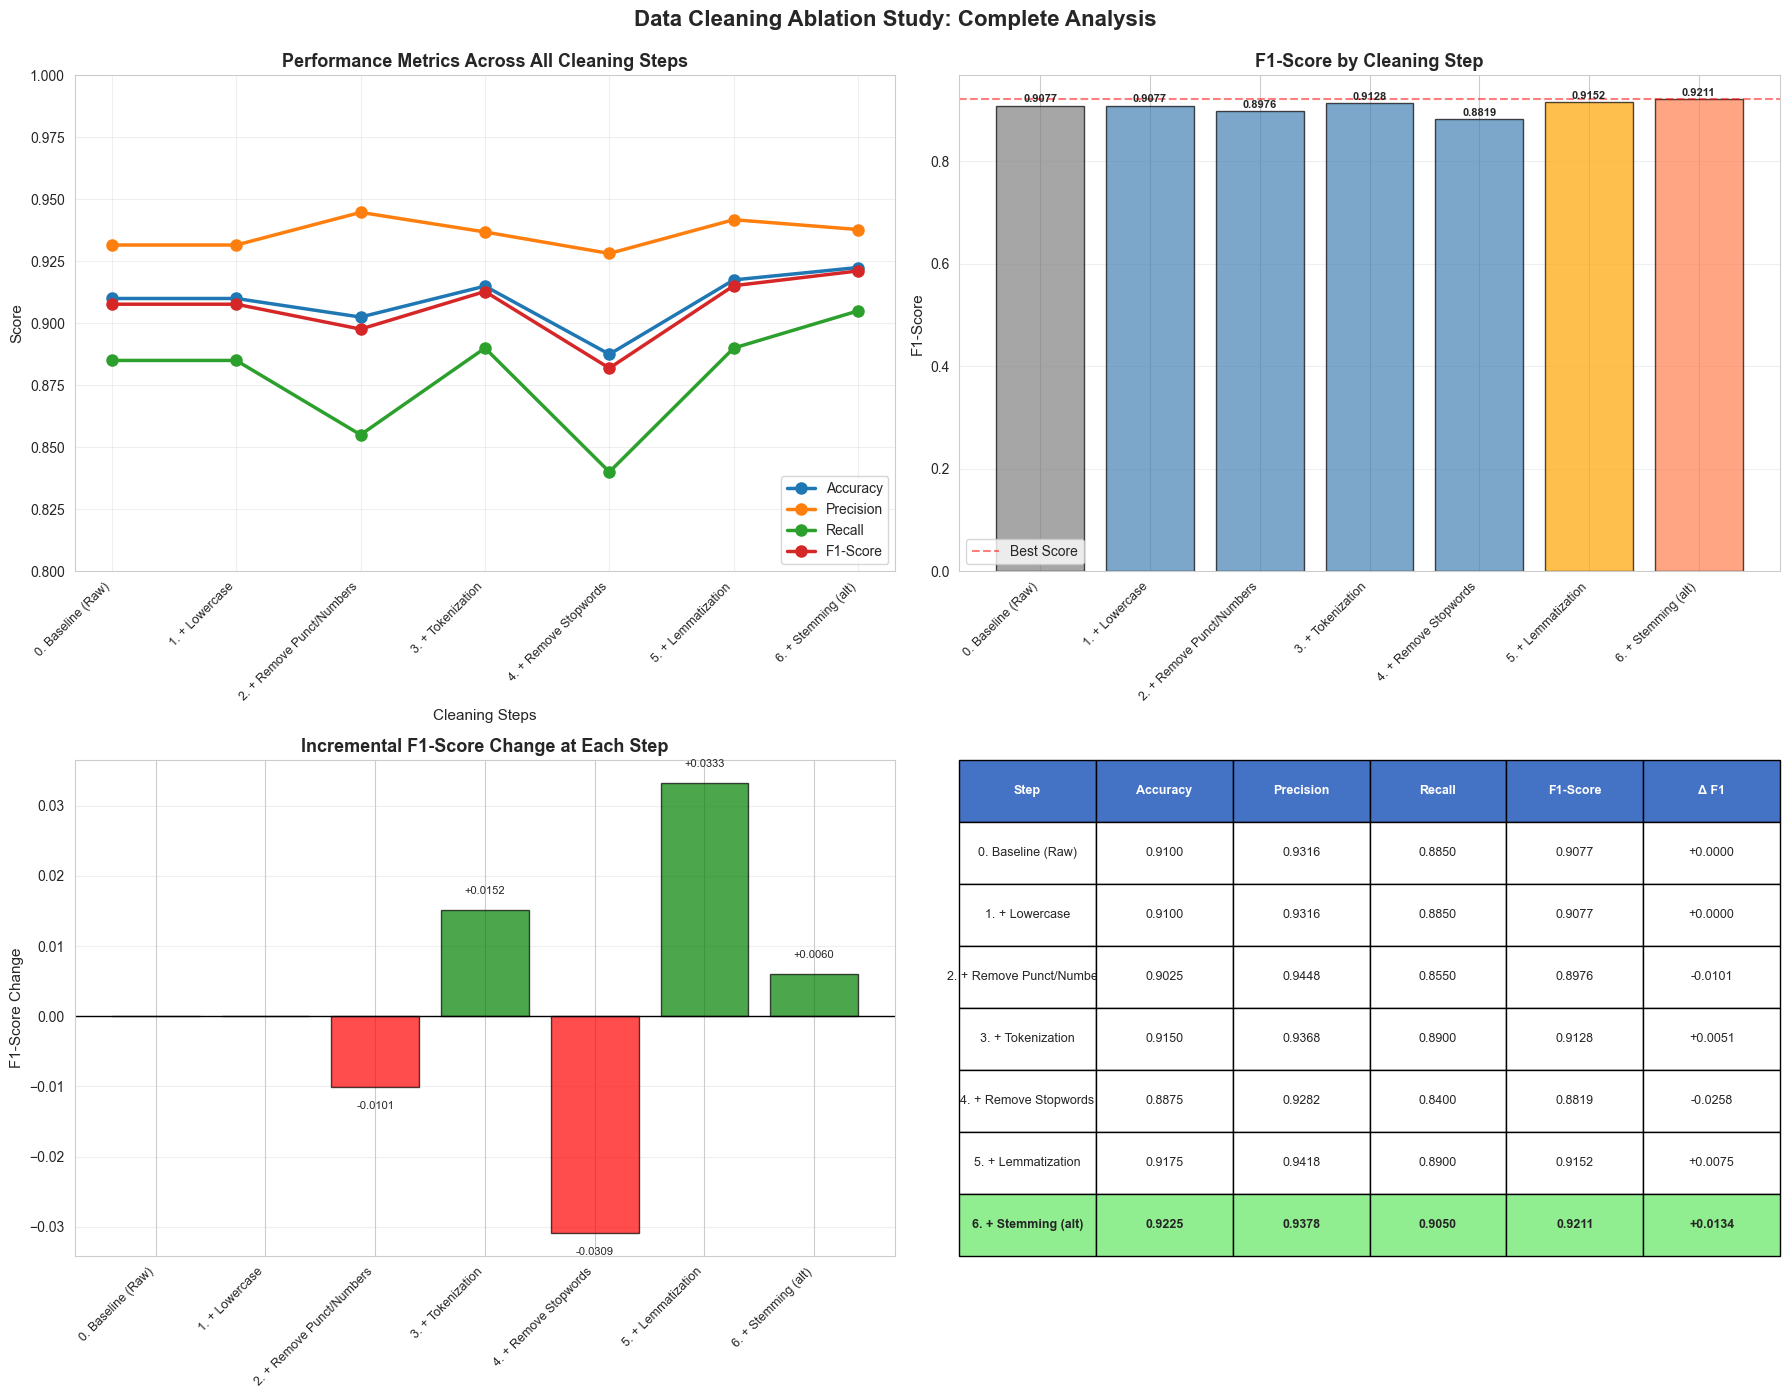

In [97]:

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: All Metrics Across All Steps
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_positions = range(len(results_df))
for metric in metrics_to_plot:
    axes[0, 0].plot(x_positions, results_df[metric], marker='o', label=metric, linewidth=2.5, markersize=8)
axes[0, 0].set_xlabel('Cleaning Steps', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Performance Metrics Across All Cleaning Steps', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0.8, 1.0])
axes[0, 0].set_xticks(x_positions)
axes[0, 0].set_xticklabels(results_df['Step'], rotation=45, ha='right', fontsize=9)

# Plot 2: F1-Score Comparison
colors_f1 = ['gray'] + ['steelblue']*(len(results_df)-3) + ['orange', 'coral']
axes[0, 1].bar(x_positions, results_df['F1-Score'], color=colors_f1, alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(x_positions)
axes[0, 1].set_xticklabels(results_df['Step'], rotation=45, ha='right', fontsize=9)
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('F1-Score by Cleaning Step', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=results_df['F1-Score'].max(), color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Best Score')
axes[0, 1].legend()
for i, v in enumerate(results_df['F1-Score']):
    axes[0, 1].text(i, v + 0.003, f'{v:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 3: Incremental Improvements
improvements = [0] + [results_df.iloc[i]['F1-Score'] - results_df.iloc[i-1]['F1-Score'] 
                      for i in range(1, len(results_df))]
colors = ['green' if x >= 0 else 'red' for x in improvements]
bars = axes[1, 0].bar(x_positions, improvements, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(x_positions)
axes[1, 0].set_xticklabels(results_df['Step'], rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('F1-Score Change', fontsize=11)
axes[1, 0].set_title('Incremental F1-Score Change at Each Step', fontsize=13, fontweight='bold')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, improvements)):
    if val != 0:
        axes[1, 0].text(i, val + (0.002 if val > 0 else -0.002), f'{val:+.4f}', 
                       ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

# Plot 4: Detailed Comparison Table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for i, row in results_df.iterrows():
    improvement = row['F1-Score'] - results_df.iloc[0]['F1-Score']
    table_data.append([
        row['Step'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1-Score']:.4f}",
        f"{improvement:+.4f}"
    ])
table = axes[1, 1].table(cellText=table_data,
                         colLabels=['Step', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Δ F1'],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color header
for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best row
best_row_idx = results_df['F1-Score'].idxmax() + 1
for i in range(6):
    table[(best_row_idx, i)].set_facecolor('#90EE90')
    table[(best_row_idx, i)].set_text_props(weight='bold')

plt.suptitle('Data Cleaning Ablation Study: Complete Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## feature engineering

In [98]:
df['cleaned_text'] = df['step6_text'] 

In [99]:
# ============================================================================
# STEP 2.4: NUMERICAL FEATURES - URL COUNT
# ============================================================================

print("="*70)
print("STEP 2.4: PROCESSING NUMERICAL FEATURES (URLs)")
print("="*70)

# Handle missing values in urls column
df['urls'] = df['urls'].fillna(0)

# Create additional URL-related features
df['has_url'] = (df['urls'] > 0).astype(int)
df['urls_log'] = np.log1p(df['urls'])  # Log transformation to handle outliers

print(f"URL Statistics:")
print(df.groupby('label')['urls'].describe())
print(f"\nHas URL by label:")
print(df.groupby('label')['has_url'].value_counts())
print()

STEP 2.4: PROCESSING NUMERICAL FEATURES (URLs)
URL Statistics:
        count   mean       std  min  25%  50%  75%  max
label                                                  
0      1000.0  0.673  0.469352  0.0  0.0  1.0  1.0  1.0
1      1000.0  0.667  0.471522  0.0  0.0  1.0  1.0  1.0

Has URL by label:
label  has_url
0      1          673
       0          327
1      1          667
       0          333
Name: count, dtype: int64



In [101]:
# ============================================================================
# STEP 2.5: DATE FEATURES - TIME-BASED PATTERNS
# ============================================================================

print("="*70)
print("STEP 2.5: PROCESSING DATE FEATURES")
print("="*70)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract time features
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)  # 10PM - 6AM

# Handle missing dates
df['hour'] = df['hour'].fillna(12)  # Default to noon
df['day_of_week'] = df['day_of_week'].fillna(2)  # Default to Wednesday

print(f"Time Feature Statistics:")
print(f"\nSpam emails by time of day:")
print(df[df['label']==1].groupby('is_night')['label'].count())
print(f"\nSpam emails on weekend:")
print(df[df['label']==1].groupby('is_weekend')['label'].count())
print()

STEP 2.5: PROCESSING DATE FEATURES
Time Feature Statistics:

Spam emails by time of day:
is_night
0    947
1     53
Name: label, dtype: int64

Spam emails on weekend:
is_weekend
0    992
1      8
Name: label, dtype: int64



In [102]:
# ============================================================================
# STEP 2.6: CATEGORICAL FEATURES - SENDER DOMAIN
# ============================================================================

print("="*70)
print("STEP 2.6: PROCESSING CATEGORICAL FEATURES (Sender Domain)")
print("="*70)

# Extract sender domain
df['sender_domain'] = df['sender'].fillna('').astype(str).apply(
    lambda x: x.split('@')[-1] if '@' in x else 'unknown'
)

# Calculate domain spam rate (target encoding)
domain_spam_rate = df.groupby('sender_domain')['label'].mean()
df['domain_spam_rate'] = df['sender_domain'].map(domain_spam_rate).fillna(0.5)

# Is domain suspicious (high spam rate)
df['is_suspicious_domain'] = (df['domain_spam_rate'] > 0.7).astype(int)

# Domain frequency
domain_freq = df['sender_domain'].value_counts()
df['domain_frequency'] = df['sender_domain'].map(domain_freq).fillna(1)
df['is_rare_domain'] = (df['domain_frequency'] <= 5).astype(int)

print(f"Top spam domains:")
print(df[df['label']==1]['sender_domain'].value_counts().head(10))
print(f"\nDomain feature statistics:")
print(df.groupby('label')[['domain_spam_rate', 'is_suspicious_domain', 'is_rare_domain']].mean())
print()

STEP 2.6: PROCESSING CATEGORICAL FEATURES (Sender Domain)
Top spam domains:
sender_domain
unknown          41
yahoo.com>       16
hotmail.com>     14
google.com>       7
virgilio.it>      5
foxnews.com>      4
netscape.net>     4
mail.com>         3
aol.com>          3
yahoo.co.uk>      3
Name: count, dtype: int64

Domain feature statistics:
       domain_spam_rate  is_suspicious_domain  is_rare_domain
label                                                        
0              0.021266                 0.006           0.681
1              0.978734                 0.969           0.916



In [103]:
# ============================================================================
# STEP 2.7: TEXT META-FEATURES - WRITING STYLE
# ============================================================================

print("="*70)
print("STEP 2.7: CREATING TEXT META-FEATURES")
print("="*70)

# Length features
df['subject_length'] = df['subject'].str.len()
df['body_length'] = df['body'].str.len()
df['text_length'] = df['full_text'].str.len()
df['word_count'] = df['full_text'].str.split().str.len()

# Character-based features
df['uppercase_count'] = df['full_text'].str.count(r'[A-Z]')
df['uppercase_ratio'] = df['uppercase_count'] / (df['text_length'] + 1)

# Special character features (spam indicators)
df['exclamation_count'] = df['full_text'].str.count('!')
df['question_count'] = df['full_text'].str.count('\?')
df['dollar_count'] = df['full_text'].str.count('\$')
df['percent_count'] = df['full_text'].str.count('%')
df['star_count'] = df['full_text'].str.count('\*')
df['special_char_total'] = (df['exclamation_count'] + df['question_count'] + 
                             df['dollar_count'] + df['percent_count'] + df['star_count'])

# Digit features
df['digit_count'] = df['full_text'].str.count(r'\d')
df['digit_ratio'] = df['digit_count'] / (df['text_length'] + 1)

# Average word length
df['avg_word_length'] = df['text_length'] / (df['word_count'] + 1)

print("Text Meta-Feature Statistics:")
print(df.groupby('label')[['text_length', 'uppercase_ratio', 'exclamation_count', 
                           'dollar_count', 'digit_ratio']].mean())
print()

STEP 2.7: CREATING TEXT META-FEATURES
Text Meta-Feature Statistics:
       text_length  uppercase_ratio  exclamation_count  dollar_count  \
label                                                                  
0         2262.453         0.051489              1.126         2.816   
1         1182.839         0.075494              1.485         0.568   

       digit_ratio  
label               
0         0.030131  
1         0.022522  



In [104]:
# Sentiment features
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    """Get compound sentiment score using VADER
        Positive values (closer to 1): indicate positive sentiment (happy, excited, optimistic).
        Negative values (closer to -1): indicate negative sentiment (angry, sad, pessimistic).
        Values near 0: indicate neutral sentiment.
    """
    if pd.isna(text):
        return 0
    return sia.polarity_scores(str(text))['compound']

df['subject_sentiment'] = df['subject'].apply(get_sentiment_score)
df['body_sentiment'] = df['body'].apply(get_sentiment_score)

In [105]:
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

In [141]:
print("="*70)
print("BASELINE: TEXT FEATURES ONLY")
print("="*70)

X_train_0 = df.loc[X_train_idx, 'cleaned_text']
X_test_0 = df.loc[X_test_idx, 'cleaned_text']

results_fe = []
metrics_0, y_pred_0 = train_and_evaluate(X_train_0, X_test_0, y_train, y_test, "0. Text Only")
results_fe.append(metrics_0)

print(f"Accuracy: {metrics_0['Accuracy']:.4f}")
print(f"Precision: {metrics_0['Precision']:.4f}")
print(f"Recall: {metrics_0['Recall']:.4f}")
print(f"F1-Score: {metrics_0['F1-Score']:.4f}")
print()

BASELINE: TEXT FEATURES ONLY
Accuracy: 0.9225
Precision: 0.9378
Recall: 0.9050
F1-Score: 0.9211



In [142]:
# ============================================================================
# Helper function to combine text and numeric features
# ============================================================================

def combine_text_numeric_features(text_series, numeric_df, train_idx, test_idx):
    """
    Combine text (via TF-IDF) and numeric features into a single feature matrix
    Returns combined train and test data as strings with numeric features appended
    """
    # Scale numeric features
    scaler = StandardScaler()
    numeric_train = scaler.fit_transform(numeric_df.iloc[train_idx])
    numeric_test = scaler.transform(numeric_df.iloc[test_idx])
    
    # Create augmented text by appending numeric features as tokens
    # This allows us to use the same train_and_evaluate function
    X_train_combined = []
    X_test_combined = []
    
    for i, idx in enumerate(train_idx):
        text = text_series.iloc[idx]
        # Append numeric features as special tokens
        numeric_tokens = ' '.join([f'NUM{j}_{int(numeric_train[i, j]*100)}' 
                                   for j in range(numeric_train.shape[1])])
        X_train_combined.append(f"{text} {numeric_tokens}")
    
    for i, idx in enumerate(test_idx):
        text = text_series.iloc[idx]
        numeric_tokens = ' '.join([f'NUM{j}_{int(numeric_test[i, j]*100)}' 
                                   for j in range(numeric_test.shape[1])])
        X_test_combined.append(f"{text} {numeric_tokens}")
    
    return pd.Series(X_train_combined), pd.Series(X_test_combined)

In [143]:
# ============================================================================
# STEP 1: ADD URL FEATURES
# ============================================================================

print("="*70)
print("STEP 1: TEXT + URL FEATURES")
print("="*70)

numeric_cols_1 = df[['urls', 'has_url', 'urls_log']]
X_train_1, X_test_1 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_1, X_train_idx, X_test_idx
)

metrics_1, y_pred_1 = train_and_evaluate(X_train_1, X_test_1, y_train, y_test, "1. + URL Features")
results_fe.append(metrics_1)

print(f"Accuracy: {metrics_1['Accuracy']:.4f}")
print(f"Precision: {metrics_1['Precision']:.4f}")
print(f"Recall: {metrics_1['Recall']:.4f}")
print(f"F1-Score: {metrics_1['F1-Score']:.4f}")
print(f"Improvement: {(metrics_1['F1-Score'] - metrics_0['F1-Score']):.4f}")
print()

STEP 1: TEXT + URL FEATURES
Accuracy: 0.9250
Precision: 0.9427
Recall: 0.9050
F1-Score: 0.9235
Improvement: 0.0023



In [144]:
# ============================================================================
# STEP 2: ADD TIME FEATURES
# ============================================================================

print("="*70)
print("STEP 2: TEXT + URL + TIME FEATURES")
print("="*70)

numeric_cols_2 = df[['urls', 'has_url', 'urls_log', 
                     'hour', 'day_of_week', 'is_weekend', 'is_night']]
X_train_2, X_test_2 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_2, X_train_idx, X_test_idx
)

metrics_2, y_pred_2 = train_and_evaluate(X_train_2, X_test_2, y_train, y_test, "2. + Time Features")
results_fe.append(metrics_2)

print(f"Accuracy: {metrics_2['Accuracy']:.4f}")
print(f"Precision: {metrics_2['Precision']:.4f}")
print(f"Recall: {metrics_2['Recall']:.4f}")
print(f"F1-Score: {metrics_2['F1-Score']:.4f}")
print(f"Improvement: {(metrics_2['F1-Score'] - metrics_1['F1-Score']):.4f}")
print()

STEP 2: TEXT + URL + TIME FEATURES
Accuracy: 0.9275
Precision: 0.9524
Recall: 0.9000
F1-Score: 0.9254
Improvement: 0.0020



In [145]:
# ============================================================================
# STEP 3: ADD SENDER DOMAIN FEATURES
# ============================================================================

print("="*70)
print("STEP 3: TEXT + URL + TIME + DOMAIN FEATURES")
print("="*70)

numeric_cols_3 = df[['urls', 'has_url', 'urls_log', 
                     'hour', 'day_of_week', 'is_weekend', 'is_night',
                     'domain_spam_rate', 'is_suspicious_domain', 
                     'domain_frequency', 'is_rare_domain']]
X_train_3, X_test_3 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_3, X_train_idx, X_test_idx
)

metrics_3, y_pred_3 = train_and_evaluate(X_train_3, X_test_3, y_train, y_test, "3. + Domain Features")
results_fe.append(metrics_3)

print(f"Accuracy: {metrics_3['Accuracy']:.4f}")
print(f"Precision: {metrics_3['Precision']:.4f}")
print(f"Recall: {metrics_3['Recall']:.4f}")
print(f"F1-Score: {metrics_3['F1-Score']:.4f}")
print(f"Improvement: {(metrics_3['F1-Score'] - metrics_2['F1-Score']):.4f}")
print()

STEP 3: TEXT + URL + TIME + DOMAIN FEATURES
Accuracy: 0.9800
Precision: 1.0000
Recall: 0.9600
F1-Score: 0.9796
Improvement: 0.0541



In [146]:
print("="*70)
print("STEP 4.1: TEXT + ALL METADATA + TEXT META-FEATURES")
print("="*70)

numeric_cols_41 = df[['urls', 'has_url', 'urls_log', 
                     
                     'hour', 'day_of_week', 'is_weekend', 'is_night',

                     'domain_spam_rate', 'is_suspicious_domain', 
                     'domain_frequency', 'is_rare_domain',

                     'subject_length', 'body_length', 'text_length', 'word_count',
                    
                     ]]
X_train_41, X_test_41 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_41, X_train_idx, X_test_idx
)

metrics_41, y_pred_41 = train_and_evaluate(X_train_41, X_test_41, y_train, y_test, "4.1 + Text Length Features")
results_fe.append(metrics_41)

print(f"Accuracy: {metrics_41['Accuracy']:.4f}")
print(f"Precision: {metrics_41['Precision']:.4f}")
print(f"Recall: {metrics_41['Recall']:.4f}")
print(f"F1-Score: {metrics_41['F1-Score']:.4f}")
print(f"Improvement: {(metrics_41['F1-Score'] - metrics_3['F1-Score']):.4f}")
print()

STEP 4.1: TEXT + ALL METADATA + TEXT META-FEATURES
Accuracy: 0.9675
Precision: 1.0000
Recall: 0.9350
F1-Score: 0.9664
Improvement: -0.0132



In [147]:
print("="*70)
print("STEP 4.2: TEXT + ALL METADATA + TEXT META-FEATURES")
print("="*70)

numeric_cols_42 = df[['urls', 'has_url', 'urls_log', 
                     
                     'hour', 'day_of_week', 'is_weekend', 'is_night',

                     'domain_spam_rate', 'is_suspicious_domain', 
                     'domain_frequency', 'is_rare_domain',

                    #  'subject_length', 'body_length', 'text_length', 'word_count',
                     'uppercase_ratio', 'exclamation_count', 'dollar_count',
                    #  'special_char_total', 'digit_ratio', 'avg_word_length'
                     ]]
X_train_4, X_test_4 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_42, X_train_idx, X_test_idx
)

metrics_42, y_pred_42 = train_and_evaluate(X_train_4, X_test_4, y_train, y_test, "4.2 + Text Characters Features")
results_fe.append(metrics_42)

print(f"Accuracy: {metrics_42['Accuracy']:.4f}")
print(f"Precision: {metrics_42['Precision']:.4f}")
print(f"Recall: {metrics_42['Recall']:.4f}")
print(f"F1-Score: {metrics_42['F1-Score']:.4f}")
print(f"Improvement: {(metrics_42['F1-Score'] - metrics_3['F1-Score']):.4f}")
print()

STEP 4.2: TEXT + ALL METADATA + TEXT META-FEATURES
Accuracy: 0.9800
Precision: 1.0000
Recall: 0.9600
F1-Score: 0.9796
Improvement: 0.0000



In [148]:
print("="*70)
print("STEP 4.3: TEXT + ALL METADATA + TEXT META-FEATURES")
print("="*70)

numeric_cols_43 = df[['urls', 'has_url', 'urls_log', 
                     
                     'hour', 'day_of_week', 'is_weekend', 'is_night',

                     'domain_spam_rate', 'is_suspicious_domain', 
                     'domain_frequency', 'is_rare_domain',

                    #  'subject_length', 'body_length', 'text_length', 'word_count',
                     'uppercase_ratio', 'exclamation_count', 'dollar_count',
                     'special_char_total', 'digit_ratio', 'avg_word_length'
                     ]]
X_train_43, X_test_43 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_43, X_train_idx, X_test_idx
)

metrics_43, y_pred_43 = train_and_evaluate(X_train_43, X_test_43, y_train, y_test, "4.3 + Style Features")
results_fe.append(metrics_43)

print(f"Accuracy: {metrics_43['Accuracy']:.4f}")
print(f"Precision: {metrics_43['Precision']:.4f}")
print(f"Recall: {metrics_43['Recall']:.4f}")
print(f"F1-Score: {metrics_43['F1-Score']:.4f}")
print(f"Improvement: {(metrics_43['F1-Score'] - metrics_3['F1-Score']):.4f}")
print()

STEP 4.3: TEXT + ALL METADATA + TEXT META-FEATURES
Accuracy: 0.9625
Precision: 1.0000
Recall: 0.9250
F1-Score: 0.9610
Improvement: -0.0186



In [149]:
# ============================================================================
# STEP 5: SENTIMENT FEATURES 
# ============================================================================

print("="*70)
print("STEP 5: TEXT + METADATA + SENTIMENT ONLY")
print("="*70)

numeric_cols_5 = df[['urls', 'has_url', 'urls_log', 
                     'hour', 'day_of_week', 'is_weekend', 'is_night',
                     'domain_spam_rate', 'is_suspicious_domain', 
                     'domain_frequency', 'is_rare_domain',
                     
                     'uppercase_ratio', 'exclamation_count', 'dollar_count',
                     
                     'subject_sentiment', 'body_sentiment']]
X_train_5, X_test_5 = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_5, X_train_idx, X_test_idx
)

metrics_5, y_pred_5 = train_and_evaluate(X_train_5, X_test_5, y_train, y_test, "5 + Sentiment Only")
results_fe.append(metrics_5)

print(f"Accuracy: {metrics_5['Accuracy']:.4f}")
print(f"Precision: {metrics_5['Precision']:.4f}")
print(f"Recall: {metrics_5['Recall']:.4f}")
print(f"F1-Score: {metrics_5['F1-Score']:.4f}")
print(f"Improvement: {(metrics_5['F1-Score'] - metrics_3['F1-Score']):.4f}")
print()

STEP 5: TEXT + METADATA + SENTIMENT ONLY
Accuracy: 0.9800
Precision: 1.0000
Recall: 0.9600
F1-Score: 0.9796
Improvement: 0.0000



In [150]:
# ============================================================================
# SUMMARY OF FEATURE ENGINEERING ABLATION
# ============================================================================

print("="*70)
print("FEATURE ENGINEERING ABLATION STUDY SUMMARY")
print("="*70)

results_fe_df = pd.DataFrame(results_fe)
print(results_fe_df.to_string(index=False))
print()

print("="*70)
print("CUMULATIVE IMPROVEMENTS FROM PREVIOUS STEP")
print("="*70)
for i in range(1, len(results_fe)):
    improvement = results_fe[i]['F1-Score'] - results_fe[i-1]['F1-Score']
    pct_improvement = improvement / results_fe[i-1]['F1-Score'] * 100
    print(f"{results_fe[i]['Step']:<40}: {improvement:+.4f} ({pct_improvement:+.2f}%)")
print()

# Best approach
best_idx = results_fe_df['F1-Score'].idxmax()
print("="*70)
print("BEST FEATURE COMBINATION")
print("="*70)
print(f"Configuration: {results_fe_df.iloc[best_idx]['Step']}")
print(f"F1-Score: {results_fe_df.iloc[best_idx]['F1-Score']:.4f}")
print(f"Accuracy: {results_fe_df.iloc[best_idx]['Accuracy']:.4f}")
print(f"Precision: {results_fe_df.iloc[best_idx]['Precision']:.4f}")
print(f"Recall: {results_fe_df.iloc[best_idx]['Recall']:.4f}")
print()

FEATURE ENGINEERING ABLATION STUDY SUMMARY
                          Step  Accuracy  Precision  Recall  F1-Score
                  0. Text Only    0.9225   0.937824   0.905  0.921120
             1. + URL Features    0.9250   0.942708   0.905  0.923469
            2. + Time Features    0.9275   0.952381   0.900  0.925450
          3. + Domain Features    0.9800   1.000000   0.960  0.979592
    4.1 + Text Length Features    0.9675   1.000000   0.935  0.966408
4.2 + Text Characters Features    0.9800   1.000000   0.960  0.979592
          4.3 + Style Features    0.9625   1.000000   0.925  0.961039
            5 + Sentiment Only    0.9800   1.000000   0.960  0.979592

CUMULATIVE IMPROVEMENTS FROM PREVIOUS STEP
1. + URL Features                       : +0.0023 (+0.26%)
2. + Time Features                      : +0.0020 (+0.21%)
3. + Domain Features                    : +0.0541 (+5.85%)
4.1 + Text Length Features              : -0.0132 (-1.35%)
4.2 + Text Characters Features          : +0.01

summary结果不对

## models

In [ ]:
# pip -q install scikit-optimize lightgbm

In [128]:
# ============================================================================
# MODEL COMPARISON WITH HYPERPARAMETER TUNING
# ============================================================================

print("="*70)
print("HYPERPARAMETER TUNING WITH BAYESIAN OPTIMIZATION")
print("="*70)

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import time

# Prepare final feature set (numeric_cols_5 + text)
print("Preparing final feature set...")
numeric_cols_5 = df[['urls', 'has_url', 'urls_log', 
                     'hour', 'day_of_week', 'is_weekend', 'is_night',
                     'domain_spam_rate', 'is_suspicious_domain', 
                     'domain_frequency', 'is_rare_domain',
                     'uppercase_ratio', 'exclamation_count', 'dollar_count',
                     'subject_sentiment', 'body_sentiment']]

X_train_final, X_test_final = combine_text_numeric_features(
    df['cleaned_text'], numeric_cols_5, X_train_idx, X_test_idx
)

# Vectorize for models that need numeric input
vectorizer_final = TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_tfidf_final = vectorizer_final.fit_transform(X_train_final)
X_test_tfidf_final = vectorizer_final.transform(X_test_final)

print(f"Training set shape: {X_train_tfidf_final.shape}")
print(f"Test set shape: {X_test_tfidf_final.shape}")
print()

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
tuning_results = []

HYPERPARAMETER TUNING WITH BAYESIAN OPTIMIZATION
Preparing final feature set...
Training set shape: (1600, 500)
Test set shape: (400, 500)



In [133]:
# ============================================================================
# MODEL 1: LOGISTIC REGRESSION - HYPERPARAMETER TUNING
# ============================================================================

print("="*70)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*70)

# Define search space
lr_search_space = {
    'C': Real(0.001, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2', 'elasticnet']),
    'solver': Categorical(['saga']),
    'l1_ratio': Real(0.0, 1.0),
    'max_iter': Categorical([1000])
}

# Initialize model
lr_model = LogisticRegression(random_state=42)

# Bayesian optimization
print("Starting Bayesian optimization...")
start_time = time.time()

lr_bayes = BayesSearchCV(
    lr_model,
    lr_search_space,
    n_iter=30,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

lr_bayes.fit(X_train_tfidf_final, y_train)

end_time = time.time()

# Best parameters
print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
print(f"Best parameters: {lr_bayes.best_params_}")
print(f"Best CV F1-Score: {lr_bayes.best_score_:.4f}")

# Evaluate on test set
y_pred_lr = lr_bayes.predict(X_test_tfidf_final)

lr_results = {
    'Model': 'Logistic Regression',
    'Best Params': str(lr_bayes.best_params_),
    'CV F1-Score': lr_bayes.best_score_,
    'Test Accuracy': accuracy_score(y_test, y_pred_lr),
    'Test Precision': precision_score(y_test, y_pred_lr),
    'Test Recall': recall_score(y_test, y_pred_lr),
    'Test F1-Score': f1_score(y_test, y_pred_lr),
    'Time (s)': end_time - start_time
}
tuning_results.append(lr_results)

print("\nTest Set Performance:")
print(f"Accuracy:  {lr_results['Test Accuracy']:.4f}")
print(f"Precision: {lr_results['Test Precision']:.4f}")
print(f"Recall:    {lr_results['Test Recall']:.4f}")
print(f"F1-Score:  {lr_results['Test F1-Score']:.4f}")
print()

MODEL 1: LOGISTIC REGRESSION
Starting Bayesian optimization...

Optimization completed in 52.00 seconds
Best parameters: OrderedDict([('C', 26.26147436053154), ('l1_ratio', 0.0), ('max_iter', 1000), ('penalty', 'l1'), ('solver', 'saga')])
Best CV F1-Score: 0.9925

Test Set Performance:
Accuracy:  0.9950
Precision: 0.9950
Recall:    0.9950
F1-Score:  0.9950



In [134]:
# ============================================================================
# MODEL 2: NAIVE BAYES - HYPERPARAMETER TUNING
# ============================================================================

print("="*70)
print("MODEL 2: MULTINOMIAL NAIVE BAYES")
print("="*70)

# Define search space
nb_search_space = {
    'alpha': Real(0.001, 10, prior='log-uniform'),
    'fit_prior': Categorical([True, False])
}

# Initialize model
nb_model = MultinomialNB()

# Bayesian optimization
print("Starting Bayesian optimization...")
start_time = time.time()

nb_bayes = BayesSearchCV(
    nb_model,
    nb_search_space,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

nb_bayes.fit(X_train_tfidf_final, y_train)

end_time = time.time()

# Best parameters
print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
print(f"Best parameters: {nb_bayes.best_params_}")
print(f"Best CV F1-Score: {nb_bayes.best_score_:.4f}")

# Evaluate on test set
y_pred_nb = nb_bayes.predict(X_test_tfidf_final)

nb_results = {
    'Model': 'Naive Bayes',
    'Best Params': str(nb_bayes.best_params_),
    'CV F1-Score': nb_bayes.best_score_,
    'Test Accuracy': accuracy_score(y_test, y_pred_nb),
    'Test Precision': precision_score(y_test, y_pred_nb),
    'Test Recall': recall_score(y_test, y_pred_nb),
    'Test F1-Score': f1_score(y_test, y_pred_nb),
    'Time (s)': end_time - start_time
}
tuning_results.append(nb_results)

print("\nTest Set Performance:")
print(f"Accuracy:  {nb_results['Test Accuracy']:.4f}")
print(f"Precision: {nb_results['Test Precision']:.4f}")
print(f"Recall:    {nb_results['Test Recall']:.4f}")
print(f"F1-Score:  {nb_results['Test F1-Score']:.4f}")
print()

MODEL 2: MULTINOMIAL NAIVE BAYES
Starting Bayesian optimization...

Optimization completed in 7.23 seconds
Best parameters: OrderedDict([('alpha', 0.0010340016434251915), ('fit_prior', False)])
Best CV F1-Score: 0.9731

Test Set Performance:
Accuracy:  0.9850
Precision: 1.0000
Recall:    0.9700
F1-Score:  0.9848



In [135]:
# ============================================================================
# MODEL 3: LIGHTGBM - HYPERPARAMETER TUNING
# ============================================================================

print("="*70)
print("MODEL 3: LIGHTGBM")
print("="*70)

# Define search space
lgbm_search_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 100),
    'min_child_samples': Integer(10, 50),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

# Initialize model
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# Bayesian optimization
print("Starting Bayesian optimization...")
start_time = time.time()

lgbm_bayes = BayesSearchCV(
    lgbm_model,
    lgbm_search_space,
    n_iter=40,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

lgbm_bayes.fit(X_train_tfidf_final, y_train)

end_time = time.time()

# Best parameters
print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
print(f"Best parameters: {lgbm_bayes.best_params_}")
print(f"Best CV F1-Score: {lgbm_bayes.best_score_:.4f}")

# Evaluate on test set
y_pred_lgbm = lgbm_bayes.predict(X_test_tfidf_final)

lgbm_results = {
    'Model': 'LightGBM',
    'Best Params': str(lgbm_bayes.best_params_),
    'CV F1-Score': lgbm_bayes.best_score_,
    'Test Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'Test Precision': precision_score(y_test, y_pred_lgbm),
    'Test Recall': recall_score(y_test, y_pred_lgbm),
    'Test F1-Score': f1_score(y_test, y_pred_lgbm),
    'Time (s)': end_time - start_time
}
tuning_results.append(lgbm_results)

print("\nTest Set Performance:")
print(f"Accuracy:  {lgbm_results['Test Accuracy']:.4f}")
print(f"Precision: {lgbm_results['Test Precision']:.4f}")
print(f"Recall:    {lgbm_results['Test Recall']:.4f}")
print(f"F1-Score:  {lgbm_results['Test F1-Score']:.4f}")
print()

MODEL 3: LIGHTGBM
Starting Bayesian optimization...

Optimization completed in 114.23 seconds
Best parameters: OrderedDict([('colsample_bytree', 0.7779330049204607), ('learning_rate', 0.18870659816091614), ('max_depth', 4), ('min_child_samples', 27), ('n_estimators', 97), ('num_leaves', 56), ('reg_alpha', 0.15544805405054332), ('reg_lambda', 0.7515525313404965), ('subsample', 0.8229361692135205)])
Best CV F1-Score: 0.9925

Test Set Performance:
Accuracy:  0.9925
Precision: 0.9900
Recall:    0.9950
F1-Score:  0.9925



In [136]:
# ============================================================================
# MODEL 4: XGBOOST - HYPERPARAMETER TUNING
# ============================================================================

print("="*70)
print("MODEL 4: XGBOOST")
print("="*70)

# Define search space
xgb_search_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0.0, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 2.0)
}

# Initialize model with updated parameters
xgb_model = XGBClassifier(
    random_state=42, 
    n_jobs=-1,
    tree_method='hist',  # More efficient
    enable_categorical=False
)

# Bayesian optimization
print("Starting Bayesian optimization...")
start_time = time.time()

xgb_bayes = BayesSearchCV(
    xgb_model,
    xgb_search_space,
    n_iter=40,
    cv=cv,
    scoring='f1',
    n_jobs=-1, 
    verbose=0,
    random_state=42
)

xgb_bayes.fit(X_train_tfidf_final, y_train)

end_time = time.time()

# Best parameters
print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
print(f"Best parameters: {xgb_bayes.best_params_}")
print(f"Best CV F1-Score: {xgb_bayes.best_score_:.4f}")

# Evaluate on test set
y_pred_xgb = xgb_bayes.predict(X_test_tfidf_final)

xgb_results = {
    'Model': 'XGBoost',
    'Best Params': str(xgb_bayes.best_params_),
    'CV F1-Score': xgb_bayes.best_score_,
    'Test Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Test Precision': precision_score(y_test, y_pred_xgb),
    'Test Recall': recall_score(y_test, y_pred_xgb),
    'Test F1-Score': f1_score(y_test, y_pred_xgb),
    'Time (s)': end_time - start_time
}
tuning_results.append(xgb_results)

print("\nTest Set Performance:")
print(f"Accuracy:  {xgb_results['Test Accuracy']:.4f}")
print(f"Precision: {xgb_results['Test Precision']:.4f}")
print(f"Recall:    {xgb_results['Test Recall']:.4f}")
print(f"F1-Score:  {xgb_results['Test F1-Score']:.4f}")
print()

MODEL 4: XGBOOST
Starting Bayesian optimization...

Optimization completed in 79.15 seconds
Best parameters: OrderedDict([('colsample_bytree', 0.7299042994818068), ('gamma', 0.5881459885167649), ('learning_rate', 0.08677665218329325), ('max_depth', 4), ('min_child_weight', 1), ('n_estimators', 154), ('reg_alpha', 0.1524286871890642), ('reg_lambda', 1.4088024766794804), ('subsample', 1.0)])
Best CV F1-Score: 0.9931

Test Set Performance:
Accuracy:  0.9925
Precision: 0.9900
Recall:    0.9950
F1-Score:  0.9925



In [137]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON
# ============================================================================

print("="*70)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("="*70)

tuning_df = pd.DataFrame(tuning_results)
print(tuning_df[['Model', 'CV F1-Score', 'Test Accuracy', 'Test Precision', 
                 'Test Recall', 'Test F1-Score', 'Time (s)']].to_string(index=False))
print()

# Best model
best_model_idx = tuning_df['Test F1-Score'].idxmax()
print("="*70)
print("BEST MODEL")
print("="*70)
print(f"Model: {tuning_df.iloc[best_model_idx]['Model']}")
print(f"CV F1-Score: {tuning_df.iloc[best_model_idx]['CV F1-Score']:.4f}")
print(f"Test F1-Score: {tuning_df.iloc[best_model_idx]['Test F1-Score']:.4f}")
print(f"Test Accuracy: {tuning_df.iloc[best_model_idx]['Test Accuracy']:.4f}")
print(f"Test Precision: {tuning_df.iloc[best_model_idx]['Test Precision']:.4f}")
print(f"Test Recall: {tuning_df.iloc[best_model_idx]['Test Recall']:.4f}")
print(f"Best Parameters: {tuning_df.iloc[best_model_idx]['Best Params']}")
print()

HYPERPARAMETER TUNING RESULTS SUMMARY
              Model  CV F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score   Time (s)
Logistic Regression     0.992468         0.9950         0.99500        0.995       0.995000  52.004825
        Naive Bayes     0.973134         0.9850         1.00000        0.970       0.984772   7.229389
           LightGBM     0.992508         0.9925         0.99005        0.995       0.992519 114.225376
            XGBoost     0.993111         0.9925         0.99005        0.995       0.992519  79.147124

BEST MODEL
Model: Logistic Regression
CV F1-Score: 0.9925
Test F1-Score: 0.9950
Test Accuracy: 0.9950
Test Precision: 0.9950
Test Recall: 0.9950
Best Parameters: OrderedDict([('C', 26.26147436053154), ('l1_ratio', 0.0), ('max_iter', 1000), ('penalty', 'l1'), ('solver', 'saga')])



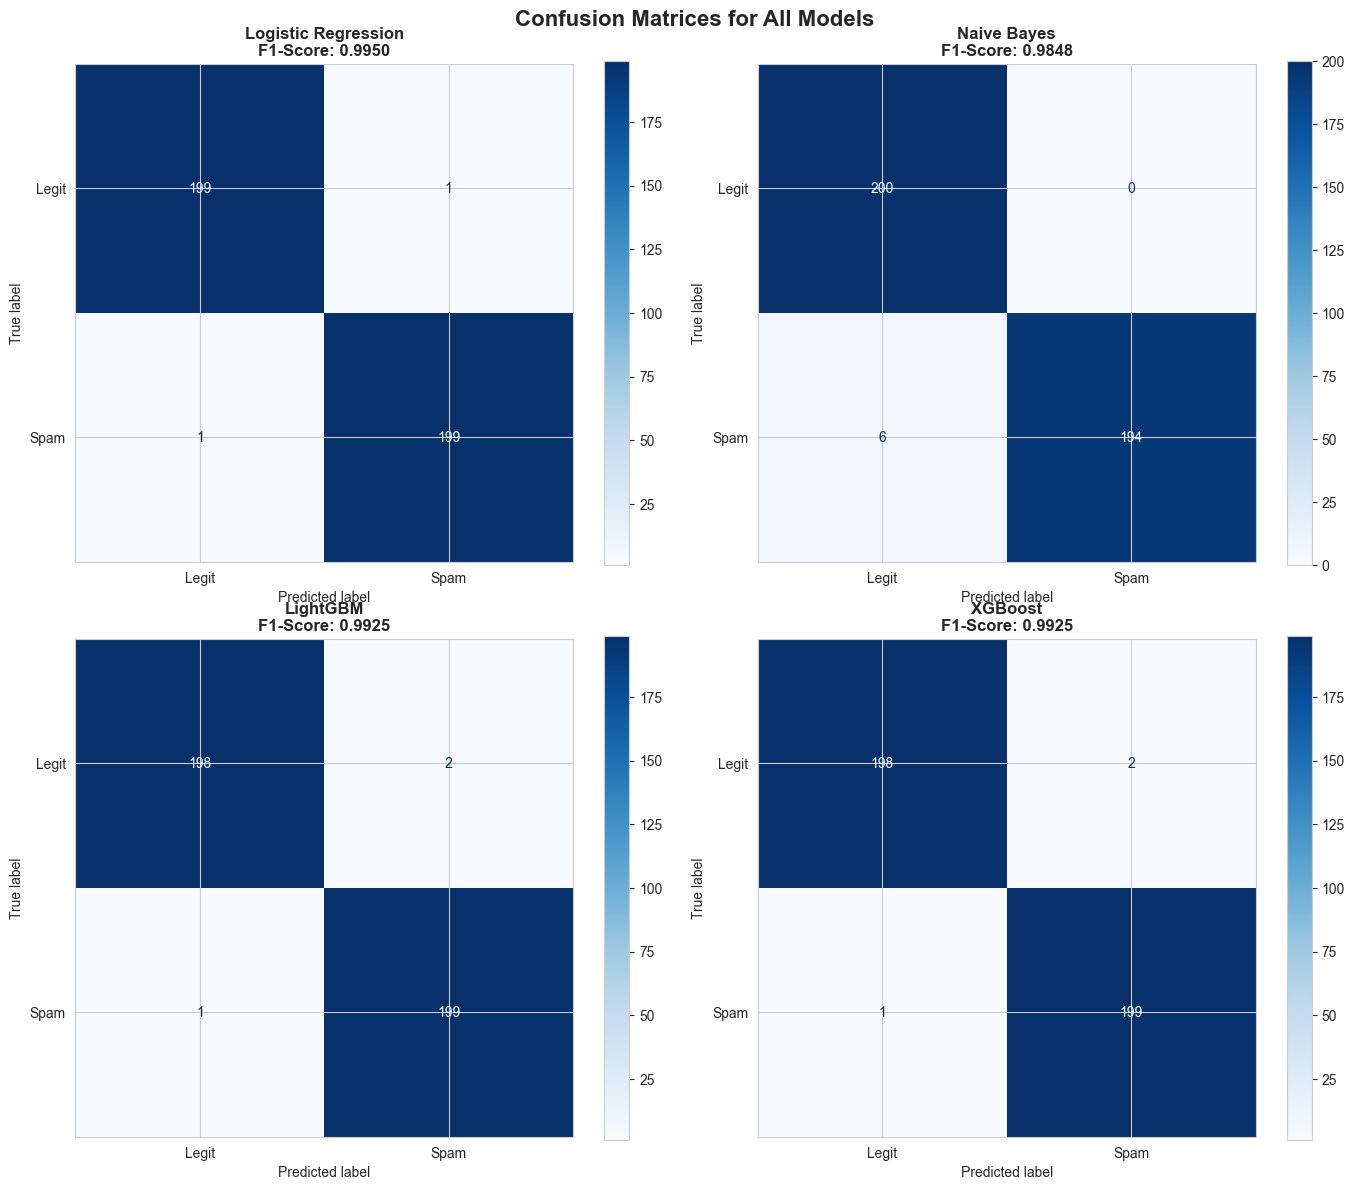

In [138]:
# ============================================================================
# CONFUSION MATRICES FOR ALL MODELS
# ============================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

predictions = [y_pred_lr, y_pred_nb, y_pred_lgbm, y_pred_xgb]
model_names = ['Logistic Regression', 'Naive Bayes', 'LightGBM', 'XGBoost']

for idx, (y_pred, name, ax) in enumerate(zip(predictions, model_names, axes.flat)):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Spam'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{name}\nF1-Score: {tuning_results[idx]["Test F1-Score"]:.4f}', 
                 fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [139]:
# ============================================================================
# SAVE BEST MODEL
# ============================================================================

import pickle

best_model_name = tuning_df.iloc[best_model_idx]['Model']
print("="*70)
print("SAVING BEST MODEL")
print("="*70)

if best_model_name == 'Logistic Regression':
    best_model = lr_bayes.best_estimator_
elif best_model_name == 'Naive Bayes':
    best_model = nb_bayes.best_estimator_
elif best_model_name == 'LightGBM':
    best_model = lgbm_bayes.best_estimator_
else:  # XGBoost
    best_model = xgb_bayes.best_estimator_

# Save model and vectorizer
with open('best_spam_classifier.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'vectorizer': vectorizer_final,
        'model_name': best_model_name,
        'feature_columns': numeric_cols_5.columns.tolist(),
        'metrics': tuning_results[best_model_idx]
    }, f)

print(f"Best model ({best_model_name}) saved to 'best_spam_classifier.pkl'")
print(f"Vectorizer and feature configuration also saved")
print()

SAVING BEST MODEL
Best model (Logistic Regression) saved to 'best_spam_classifier.pkl'
Vectorizer and feature configuration also saved



### bert

In [ ]:
# !pip -q install transformers torch datasets accelerate tensorboard

In [ ]:
# pip uninstall tensorflow -y

In [1]:
# ============================================================================
# BERT MODEL
# ============================================================================

import torch
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

print("="*70)
print("BERT MODEL PREPARATION")
print("="*70)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print()

df_bert = pd.read_csv("merged_csv.csv")

# Downsample if needed (BERT is computationally expensive)
df_bert_sampled = df_bert.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 1000), random_state=42)
).sample(frac=1, random_state=42).reset_index(drop=True)

df_bert = df_bert_sampled

df_bert['subject'] = df_bert['subject'].fillna('')
df_bert['body'] = df_bert['body'].fillna('')

df_bert['text'] = df_bert['subject'] + ' [SEP] ' + df_bert['body']

# Truncate very long texts (BERT has 512 token limit)
df_bert['text'] = df_bert['text'].str[:1000]  # Rough character limit

print(f"Total samples: {len(df_bert)}")
print(f"Class distribution:\n{df_bert['label'].value_counts()}")
print()

BERT MODEL PREPARATION
Using device: mps

Total samples: 2000
Class distribution:
label
1    1000
0    1000
Name: count, dtype: int64



/var/folders/3m/ld95k1wd7n3_j6d0pxsvvdbw0000gn/T/ipykernel_71553/3104483462.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bert_sampled = df_bert.groupby('label', group_keys=False).apply(


In [2]:
# ============================================================================
# SPLIT DATA
# ============================================================================

from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_bert['text'].tolist(),
    df_bert['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_bert['label']
)

# Further split train into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.1,
    random_state=42,
    stratify=train_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")
print()

Training samples: 1440
Validation samples: 160
Test samples: 400



In [3]:
# ============================================================================
# TOKENIZATION
# ============================================================================

print("="*70)
print("TOKENIZING TEXT")
print("="*70)

# Load pre-trained BERT tokenizer
# Options: 'bert-base-uncased', 'bert-base-cased', 'distilbert-base-uncased'
model_name = 'bert-base-uncased'  # Faster and works well
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize datasets
print("Tokenizing training data...")
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

print("Tokenizing validation data...")
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

print("Tokenizing test data...")
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

print("Tokenization complete!")
print()

TOKENIZING TEXT


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing training data...
Tokenizing validation data...
Tokenizing test data...
Tokenization complete!



In [4]:
# ============================================================================
# CREATE PYTORCH DATASETS
# ============================================================================

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SpamDataset(train_encodings, train_labels)
val_dataset = SpamDataset(val_encodings, val_labels)
test_dataset = SpamDataset(test_encodings, test_labels)

print(f"Datasets created successfully!")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print()

Datasets created successfully!
Train size: 1440
Validation size: 160
Test size: 400



In [5]:
# ============================================================================
# LOAD BERT MODEL
# ============================================================================

print("="*70)
print("LOADING BERT MODEL")
print("="*70)

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    problem_type="single_label_classification"
)

model.to(device)
print(f"Model loaded: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")
print()

LOADING BERT MODEL


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Model loaded: bert-base-uncased
Number of parameters: 109,483,778



In [6]:
# ============================================================================
# DEFINE EVALUATION METRICS
# ============================================================================

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [10]:
# ============================================================================
# TRAINING ARGUMENTS
# ============================================================================

print("="*70)
print("SETTING UP TRAINING")
print("="*70)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  
    per_device_train_batch_size=32,  # Adjust based on GPU memory
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,  # Keep only 2 best checkpoints
    report_to="tensorboard"  # Disable wandb/tensorboard
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print()

SETTING UP TRAINING
Training configuration:
  Epochs: 1
  Batch size: 32
  Learning rate: 5e-05



In [ ]:
# %reload_ext tensorboard

In [7]:
import os
os.system("pkill -f tensorboard")

import time
time.sleep(2)

import shutil
if os.path.exists('./logs'):
    shutil.rmtree('./logs')
os.makedirs('./logs', exist_ok=True)

# %load_ext tensorboard
# %tensorboard --logdir ./logs

In [11]:
# ============================================================================
# TRAIN MODEL
# ============================================================================

print("="*70)
print("TRAINING BERT MODEL")
print("="*70)

start_time = time.time()
train_result = trainer.train()
end_time = time.time()

print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
print(f"Training loss: {train_result.training_loss:.4f}")
print()

TRAINING BERT MODEL


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/45 [00:00<?, ?it/s]

{'loss': 0.683, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.02}
{'loss': 0.7323, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}
{'loss': 0.7335, 'learning_rate': 1.5e-06, 'epoch': 0.07}
{'loss': 0.7005, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.09}
{'loss': 0.727, 'learning_rate': 2.5e-06, 'epoch': 0.11}
{'loss': 0.6936, 'learning_rate': 3e-06, 'epoch': 0.13}
{'loss': 0.6189, 'learning_rate': 3.5000000000000004e-06, 'epoch': 0.16}
{'loss': 0.705, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.18}
{'loss': 0.6542, 'learning_rate': 4.5e-06, 'epoch': 0.2}
{'loss': 0.6841, 'learning_rate': 5e-06, 'epoch': 0.22}
{'loss': 0.6224, 'learning_rate': 5.500000000000001e-06, 'epoch': 0.24}
{'loss': 0.6152, 'learning_rate': 6e-06, 'epoch': 0.27}
{'loss': 0.6516, 'learning_rate': 6.5000000000000004e-06, 'epoch': 0.29}
{'loss': 0.5779, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.31}
{'loss': 0.5709, 'learning_rate': 7.5e-06, 'epoch': 0.33}
{'loss': 0.5992, 'learni

In [ ]:
# ============================================================================
# EVALUATE ON TEST SET
# ============================================================================

print("="*70)
print("EVALUATING ON TEST SET")
print("="*70)

test_results = trainer.evaluate(test_dataset)

print("Test Set Results:")
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1-Score:  {test_results['eval_f1']:.4f}")
print()

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred_bert = predictions.predictions.argmax(-1)

# Add to results
bert_results = {
    'Model': 'BERT',
    'Best Params': f'model={model_name}, epochs=3',
    'CV F1-Score': 0.0,  # Not applicable for BERT training
    'Test Accuracy': test_results['eval_accuracy'],
    'Test Precision': test_results['eval_precision'],
    'Test Recall': test_results['eval_recall'],
    'Test F1-Score': test_results['eval_f1'],
    'Time (s)': end_time - start_time
}
# tuning_results.append(bert_results)

EVALUATING ON TEST SET


  0%|          | 0/13 [00:00<?, ?it/s]

Test Set Results:
  Accuracy:  0.9600
  Precision: 0.9646
  Recall:    0.9550
  F1-Score:  0.9598



  0%|          | 0/13 [00:00<?, ?it/s]

NameError: name 'tuning_results' is not defined

In [ ]:
# ============================================================================
# IMPROVED TRAINING ARGUMENTS TO PREVENT OVERFITTING
# ============================================================================

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Increase epochs but stop early if needed
    
    # Batch size
    per_device_train_batch_size=16,  # Smaller batch = more regularization
    per_device_eval_batch_size=32,
    
    # Learning rate - REDUCE IT
    learning_rate=2e-5,  # Lower learning rate (was 5e-5)
    warmup_steps=200,    # More warmup steps
    
    # Regularization
    weight_decay=0.1,    # Increase from 0.01 to 0.1
    
    # Dropout (add to model configuration)
    # This will be set when loading the model
    
    # Evaluation & Early Stopping
    evaluation_strategy="steps",
    eval_steps=50,       # Evaluate more frequently
    save_strategy="steps",
    save_steps=50,
    
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    
    # Logging
    logging_dir='./logs',
    logging_steps=1,    # Log less frequently
    
    # Checkpointing
    save_total_limit=3,
    
    report_to="tensorboard"
)

# Add early stopping with more patience
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Increase patience
)

In [9]:
# ============================================================================
# TRAIN MODEL
# ============================================================================

print("="*70)
print("TRAINING BERT MODEL")
print("="*70)

start_time = time.time()
train_result = trainer.train()
end_time = time.time()

print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
print(f"Training loss: {train_result.training_loss:.4f}")
print()

TRAINING BERT MODEL


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.7582, 'learning_rate': 1.0000000000000001e-07, 'epoch': 0.01}
{'loss': 0.7442, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.02}
{'loss': 0.6905, 'learning_rate': 3.0000000000000004e-07, 'epoch': 0.03}
{'loss': 0.774, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.04}
{'loss': 0.7517, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.06}
{'loss': 0.7364, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.07}
{'loss': 0.7674, 'learning_rate': 7.000000000000001e-07, 'epoch': 0.08}
{'loss': 0.7504, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.09}
{'loss': 0.7106, 'learning_rate': 9.000000000000001e-07, 'epoch': 0.1}
{'loss': 0.7466, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.11}
{'loss': 0.7235, 'learning_rate': 1.1e-06, 'epoch': 0.12}
{'loss': 0.7434, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.13}
{'loss': 0.7116, 'learning_rate': 1.3e-06, 'epoch': 0.14}
{'loss': 0.697, 'learning_rate': 1.4000000000000001e-06, 'epoch': 0.16}
{'loss': 0.71, '

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.45033082365989685, 'eval_accuracy': 0.88125, 'eval_precision': 0.8674698795180723, 'eval_recall': 0.9, 'eval_f1': 0.8834355828220859, 'eval_runtime': 4.516, 'eval_samples_per_second': 35.43, 'eval_steps_per_second': 1.107, 'epoch': 0.56}
{'loss': 0.4673, 'learning_rate': 5.1e-06, 'epoch': 0.57}
{'loss': 0.261, 'learning_rate': 5.2e-06, 'epoch': 0.58}
{'loss': 0.4056, 'learning_rate': 5.300000000000001e-06, 'epoch': 0.59}
{'loss': 0.3584, 'learning_rate': 5.400000000000001e-06, 'epoch': 0.6}
{'loss': 0.4102, 'learning_rate': 5.500000000000001e-06, 'epoch': 0.61}
{'loss': 0.3206, 'learning_rate': 5.600000000000001e-06, 'epoch': 0.62}
{'loss': 0.4163, 'learning_rate': 5.7e-06, 'epoch': 0.63}
{'loss': 0.2646, 'learning_rate': 5.8e-06, 'epoch': 0.64}
{'loss': 0.2469, 'learning_rate': 5.9e-06, 'epoch': 0.66}
{'loss': 0.3425, 'learning_rate': 6e-06, 'epoch': 0.67}
{'loss': 0.3428, 'learning_rate': 6.1e-06, 'epoch': 0.68}
{'loss': 0.2552, 'learning_rate': 6.200000000000001e-06,

/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

In [ ]:
# ============================================================================
# EVALUATE ON TEST SET
# ============================================================================

print("="*70)
print("EVALUATING ON TEST SET")
print("="*70)

test_results = trainer.evaluate(test_dataset)

print("Test Set Results:")
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1-Score:  {test_results['eval_f1']:.4f}")
print()

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred_bert = predictions.predictions.argmax(-1)

# Add to results
bert_results = {
    'Model': 'BERT',
    'Best Params': f'model={model_name}, epochs=3',
    'CV F1-Score': 0.0,  # Not applicable for BERT training
    'Test Accuracy': test_results['eval_accuracy'],
    'Test Precision': test_results['eval_precision'],
    'Test Recall': test_results['eval_recall'],
    'Test F1-Score': test_results['eval_f1'],
    'Time (s)': end_time - start_time
}
tuning_results.append(bert_results)

EVALUATING ON TEST SET


  0%|          | 0/13 [00:00<?, ?it/s]

Test Set Results:
  Accuracy:  0.8825
  Precision: 0.8806
  Recall:    0.8850
  F1-Score:  0.8828



  0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
# ============================================================================
# QUICK GRID SEARCH - TEST 6 CONFIGS
# ============================================================================

configs = [
    {'lr': 2e-5, 'warmup': 0.1, 'wd': 0.01, 'bs': 32, 'epochs': 2},
    {'lr': 3e-5, 'warmup': 0.1, 'wd': 0.01, 'bs': 32, 'epochs': 2},
    {'lr': 5e-5, 'warmup': 0.1, 'wd': 0.01, 'bs': 32, 'epochs': 2},
    {'lr': 2e-5, 'warmup': 0.2, 'wd': 0.05, 'bs': 16, 'epochs': 2},
    {'lr': 3e-5, 'warmup': 0.0, 'wd': 0.1, 'bs': 32, 'epochs': 2},
    {'lr': 4e-5, 'warmup': 0.15, 'wd': 0.02, 'bs': 24, 'epochs': 2},
]

results = []

for i, config in enumerate(configs):
    print(f"\n{'='*70}")
    print(f"CONFIG {i+1}/6: {config}")
    print(f"{'='*70}")
    
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
    
    training_args = TrainingArguments(
        output_dir=f'./results_config{i}',
        num_train_epochs=config['epochs'],
        per_device_train_batch_size=config['bs'],
        per_device_eval_batch_size=32,
        
        learning_rate=config['lr'],
        warmup_ratio=config['warmup'],
        weight_decay=config['wd'],
        lr_scheduler_type='cosine',
        
        evaluation_strategy="steps",
        eval_steps=50,
        save_strategy="steps",
        save_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        
        logging_steps=10,
        save_total_limit=1,
        report_to="none"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    trainer.train()
    eval_results = trainer.evaluate(val_dataset)
    
    results.append({
        'config': i+1,
        **config,
        'val_f1': eval_results['eval_f1'],
        'val_accuracy': eval_results['eval_accuracy']
    })
    
    print(f"✅ F1-Score: {eval_results['eval_f1']:.4f}")
    
    # Cleanup
    import shutil
    if os.path.exists(f'./results_config{i}'):
        shutil.rmtree(f'./results_config{i}')

# Results
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("GRID SEARCH RESULTS")
print("="*70)
print(results_df.sort_values('val_f1', ascending=False))

best = results_df.loc[results_df['val_f1'].idxmax()]
print(f"\n🎯 BEST CONFIG: {best['config']}")
print(f"   F1-Score: {best['val_f1']:.4f}")
print(f"   LR={best['lr']:.2e}, Warmup={best['warmup']}, WD={best['wd']}, BS={best['bs']}")


CONFIG 1/6: {'lr': 2e-05, 'warmup': 0.1, 'wd': 0.01, 'bs': 32, 'epochs': 2}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.6515, 'learning_rate': 1.9992479525042305e-05, 'epoch': 0.22}
{'loss': 0.4849, 'learning_rate': 1.9103629409661468e-05, 'epoch': 0.44}
{'loss': 0.3161, 'learning_rate': 1.686241637868734e-05, 'epoch': 0.67}
{'loss': 0.2105, 'learning_rate': 1.3601777248047105e-05, 'epoch': 0.89}
{'loss': 0.127, 'learning_rate': 9.806086682281759e-06, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.14716729521751404, 'eval_accuracy': 0.95, 'eval_precision': 0.9615384615384616, 'eval_recall': 0.9375, 'eval_f1': 0.9493670886075949, 'eval_runtime': 4.2551, 'eval_samples_per_second': 37.602, 'eval_steps_per_second': 1.175, 'epoch': 1.11}
{'loss': 0.1207, 'learning_rate': 6.039202339608432e-06, 'epoch': 1.33}
{'loss': 0.1086, 'learning_rate': 2.8607026544210115e-06, 'epoch': 1.56}
{'loss': 0.0726, 'learning_rate': 7.427603073110967e-07, 'epoch': 1.78}
{'loss': 0.0851, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 321.4412, 'train_samples_per_second': 8.96, 'train_steps_per_second': 0.28, 'train_loss': 0.24188794957266913, 'epoch': 2.0}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

  0%|          | 0/5 [00:00<?, ?it/s]

✅ F1-Score: 0.9494

CONFIG 2/6: {'lr': 3e-05, 'warmup': 0.1, 'wd': 0.01, 'bs': 32, 'epochs': 2}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificatio

  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.627, 'learning_rate': 2.9988719287563452e-05, 'epoch': 0.22}
{'loss': 0.424, 'learning_rate': 2.86554441144922e-05, 'epoch': 0.44}
{'loss': 0.211, 'learning_rate': 2.5293624568031008e-05, 'epoch': 0.67}
{'loss': 0.154, 'learning_rate': 2.0402665872070656e-05, 'epoch': 0.89}
{'loss': 0.0656, 'learning_rate': 1.4709130023422636e-05, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.12048037350177765, 'eval_accuracy': 0.95625, 'eval_precision': 0.974025974025974, 'eval_recall': 0.9375, 'eval_f1': 0.9554140127388535, 'eval_runtime': 4.0428, 'eval_samples_per_second': 39.576, 'eval_steps_per_second': 1.237, 'epoch': 1.11}
{'loss': 0.0807, 'learning_rate': 9.058803509412647e-06, 'epoch': 1.33}
{'loss': 0.0547, 'learning_rate': 4.2910539816315166e-06, 'epoch': 1.56}
{'loss': 0.0411, 'learning_rate': 1.114140460966645e-06, 'epoch': 1.78}
{'loss': 0.0624, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 322.9606, 'train_samples_per_second': 8.917, 'train_steps_per_second': 0.279, 'train_loss': 0.1911677360534668, 'epoch': 2.0}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

  0%|          | 0/5 [00:00<?, ?it/s]

✅ F1-Score: 0.9554

CONFIG 3/6: {'lr': 5e-05, 'warmup': 0.1, 'wd': 0.01, 'bs': 32, 'epochs': 2}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificatio

  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.5971, 'learning_rate': 4.998119881260576e-05, 'epoch': 0.22}
{'loss': 0.3268, 'learning_rate': 4.775907352415367e-05, 'epoch': 0.44}
{'loss': 0.1493, 'learning_rate': 4.215604094671835e-05, 'epoch': 0.67}
{'loss': 0.122, 'learning_rate': 3.400444312011776e-05, 'epoch': 0.89}
{'loss': 0.0608, 'learning_rate': 2.4515216705704395e-05, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.07914187014102936, 'eval_accuracy': 0.96875, 'eval_precision': 0.987012987012987, 'eval_recall': 0.95, 'eval_f1': 0.9681528662420382, 'eval_runtime': 4.0554, 'eval_samples_per_second': 39.453, 'eval_steps_per_second': 1.233, 'epoch': 1.11}
{'loss': 0.0908, 'learning_rate': 1.509800584902108e-05, 'epoch': 1.33}
{'loss': 0.0465, 'learning_rate': 7.1517566360525284e-06, 'epoch': 1.56}
{'loss': 0.0229, 'learning_rate': 1.8569007682777417e-06, 'epoch': 1.78}
{'loss': 0.0695, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 310.7678, 'train_samples_per_second': 9.267, 'train_steps_per_second': 0.29, 'train_loss': 0.16507929066816965, 'epoch': 2.0}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

  0%|          | 0/5 [00:00<?, ?it/s]

✅ F1-Score: 0.9682

CONFIG 4/6: {'lr': 2e-05, 'warmup': 0.2, 'wd': 0.05, 'bs': 16, 'epochs': 2}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificatio

  0%|          | 0/180 [00:00<?, ?it/s]

{'loss': 0.6931, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.11}
{'loss': 0.6032, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.22}
{'loss': 0.4865, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.33}
{'loss': 0.3934, 'learning_rate': 1.9961946980917457e-05, 'epoch': 0.44}
{'loss': 0.2725, 'learning_rate': 1.953716950748227e-05, 'epoch': 0.56}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.22755315899848938, 'eval_accuracy': 0.925, 'eval_precision': 0.8953488372093024, 'eval_recall': 0.9625, 'eval_f1': 0.927710843373494, 'eval_runtime': 4.0836, 'eval_samples_per_second': 39.181, 'eval_steps_per_second': 1.224, 'epoch': 0.56}
{'loss': 0.1764, 'learning_rate': 1.866025403784439e-05, 'epoch': 0.67}
{'loss': 0.1306, 'learning_rate': 1.737277336810124e-05, 'epoch': 0.78}
{'loss': 0.1626, 'learning_rate': 1.573576436351046e-05, 'epoch': 0.89}
{'loss': 0.093, 'learning_rate': 1.3826834323650899e-05, 'epoch': 1.0}
{'loss': 0.0597, 'learning_rate': 1.1736481776669307e-05, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.06591729074716568, 'eval_accuracy': 0.975, 'eval_precision': 1.0, 'eval_recall': 0.95, 'eval_f1': 0.9743589743589743, 'eval_runtime': 4.1699, 'eval_samples_per_second': 38.37, 'eval_steps_per_second': 1.199, 'epoch': 1.11}
{'loss': 0.0723, 'learning_rate': 9.563806126346643e-06, 'epoch': 1.22}
{'loss': 0.0929, 'learning_rate': 7.411809548974792e-06, 'epoch': 1.33}
{'loss': 0.0951, 'learning_rate': 5.3825138676496626e-06, 'epoch': 1.44}
{'loss': 0.0323, 'learning_rate': 3.5721239031346067e-06, 'epoch': 1.56}
{'loss': 0.019, 'learning_rate': 2.0664665970876496e-06, 'epoch': 1.67}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.06222423166036606, 'eval_accuracy': 0.98125, 'eval_precision': 0.9873417721518988, 'eval_recall': 0.975, 'eval_f1': 0.9811320754716981, 'eval_runtime': 4.1639, 'eval_samples_per_second': 38.426, 'eval_steps_per_second': 1.201, 'epoch': 1.67}
{'loss': 0.0399, 'learning_rate': 9.369221296335007e-07, 'epoch': 1.78}
{'loss': 0.0407, 'learning_rate': 2.370399288006664e-07, 'epoch': 1.89}
{'loss': 0.1021, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 320.4112, 'train_samples_per_second': 8.988, 'train_steps_per_second': 0.562, 'train_loss': 0.19807617018620174, 'epoch': 2.0}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

  0%|          | 0/5 [00:00<?, ?it/s]

✅ F1-Score: 0.9811

CONFIG 5/6: {'lr': 3e-05, 'warmup': 0.0, 'wd': 0.1, 'bs': 32, 'epochs': 2}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificatio

  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.5011, 'learning_rate': 2.9095389311788626e-05, 'epoch': 0.22}
{'loss': 0.321, 'learning_rate': 2.649066664678467e-05, 'epoch': 0.44}
{'loss': 0.1992, 'learning_rate': 2.25e-05, 'epoch': 0.67}
{'loss': 0.1423, 'learning_rate': 1.760472266500396e-05, 'epoch': 0.89}
{'loss': 0.0785, 'learning_rate': 1.2395277334996045e-05, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.11534728854894638, 'eval_accuracy': 0.9625, 'eval_precision': 0.9868421052631579, 'eval_recall': 0.9375, 'eval_f1': 0.9615384615384616, 'eval_runtime': 4.1774, 'eval_samples_per_second': 38.302, 'eval_steps_per_second': 1.197, 'epoch': 1.11}
{'loss': 0.0934, 'learning_rate': 7.500000000000004e-06, 'epoch': 1.33}
{'loss': 0.0645, 'learning_rate': 3.5093333532153316e-06, 'epoch': 1.56}
{'loss': 0.0328, 'learning_rate': 9.046106882113753e-07, 'epoch': 1.78}
{'loss': 0.065, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 319.2716, 'train_samples_per_second': 9.021, 'train_steps_per_second': 0.282, 'train_loss': 0.16643772919972738, 'epoch': 2.0}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

  0%|          | 0/5 [00:00<?, ?it/s]

✅ F1-Score: 0.9615

CONFIG 6/6: {'lr': 4e-05, 'warmup': 0.15, 'wd': 0.02, 'bs': 24, 'epochs': 2}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificatio

  0%|          | 0/120 [00:00<?, ?it/s]

{'loss': 0.6483, 'learning_rate': 2.2222222222222227e-05, 'epoch': 0.17}
{'loss': 0.4695, 'learning_rate': 3.9962066574740886e-05, 'epoch': 0.33}
{'loss': 0.2823, 'learning_rate': 3.864944458808712e-05, 'epoch': 0.5}
{'loss': 0.1613, 'learning_rate': 3.558161149051341e-05, 'epoch': 0.67}
{'loss': 0.1013, 'learning_rate': 3.104729945921012e-05, 'epoch': 0.83}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.12575194239616394, 'eval_accuracy': 0.94375, 'eval_precision': 1.0, 'eval_recall': 0.8875, 'eval_f1': 0.9403973509933775, 'eval_runtime': 4.3916, 'eval_samples_per_second': 36.433, 'eval_steps_per_second': 1.139, 'epoch': 0.83}
{'loss': 0.0767, 'learning_rate': 2.5473259801441663e-05, 'epoch': 1.0}
{'loss': 0.0503, 'learning_rate': 1.9384098828876597e-05, 'epoch': 1.17}
{'loss': 0.0435, 'learning_rate': 1.3352904010406811e-05, 'epoch': 1.33}
{'loss': 0.0312, 'learning_rate': 7.947307272414874e-06, 'epoch': 1.5}
{'loss': 0.0087, 'learning_rate': 3.6760617528755682e-06, 'epoch': 1.67}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.061557430773973465, 'eval_accuracy': 0.9875, 'eval_precision': 0.9875, 'eval_recall': 0.9875, 'eval_f1': 0.9875, 'eval_runtime': 4.2381, 'eval_samples_per_second': 37.753, 'eval_steps_per_second': 1.18, 'epoch': 1.67}
{'loss': 0.0219, 'learning_rate': 9.411599914568703e-07, 'epoch': 1.83}
{'loss': 0.0722, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 335.8083, 'train_samples_per_second': 8.576, 'train_steps_per_second': 0.357, 'train_loss': 0.16394553184509278, 'epoch': 2.0}


/Users/leizhenyu/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

  0%|          | 0/5 [00:00<?, ?it/s]

✅ F1-Score: 0.9875

GRID SEARCH RESULTS
   config       lr  warmup    wd  bs  epochs    val_f1  val_accuracy
5       6  0.00004    0.15  0.02  24       2  0.987500       0.98750
3       4  0.00002    0.20  0.05  16       2  0.981132       0.98125
2       3  0.00005    0.10  0.01  32       2  0.968153       0.96875
4       5  0.00003    0.00  0.10  32       2  0.961538       0.96250
1       2  0.00003    0.10  0.01  32       2  0.955414       0.95625
0       1  0.00002    0.10  0.01  32       2  0.949367       0.95000

🎯 BEST CONFIG: 6.0
   F1-Score: 0.9875
   LR=4.00e-05, Warmup=0.15, WD=0.02, BS=24.0


In [ ]:
# ============================================================================
# AFTER GRID SEARCH COMPLETES - TRAIN AND SAVE BEST MODEL
# ============================================================================

import os
import json
import shutil

print("="*70)
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*70)

# Get best configuration from grid search results
best = results_df.loc[results_df['val_f1'].idxmax()]

print(f"Best configuration from grid search:")
print(f"  Config: {best['config']}")
print(f"  Validation F1-Score: {best['val_f1']:.4f}")
print(f"  Learning rate: {best['lr']:.2e}")
print(f"  Warmup ratio: {best['warmup']}")
print(f"  Weight decay: {best['wd']}")
print(f"  Batch size: {int(best['bs'])}")
print()

# Train final model with best hyperparameters on full training data
print("Training final model...")
final_model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)
final_model.to(device)

training_args_final = TrainingArguments(
    output_dir='./final_model',
    num_train_epochs=int(best['epochs']),
    per_device_train_batch_size=int(best['bs']),
    per_device_eval_batch_size=32,
    
    learning_rate=best['lr'],
    warmup_ratio=best['warmup'],
    weight_decay=best['wd'],
    lr_scheduler_type='cosine',
    
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=1,
    
    logging_steps=10,
    report_to="none"
)

trainer_final = Trainer(
    model=final_model,
    args=training_args_final,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train
trainer_final.train()

# Evaluate on test set
test_results_final = trainer_final.evaluate(test_dataset)
print("\nFinal Model Test Results:")
print(f"  Accuracy:  {test_results_final['eval_accuracy']:.4f}")
print(f"  Precision: {test_results_final['eval_precision']:.4f}")
print(f"  Recall:    {test_results_final['eval_recall']:.4f}")
print(f"  F1-Score:  {test_results_final['eval_f1']:.4f}")
print()

# ============================================================================
# SAVE MODEL AND TOKENIZER
# ============================================================================

save_directory = "./saved_bert_model"
os.makedirs(save_directory, exist_ok=True)

print("="*70)
print("SAVING MODEL")
print("="*70)

# Save model and tokenizer
trainer_final.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

# Save hyperparameters and metrics
config = {
    'model_name': model_name,
    'best_hyperparameters': {
        'learning_rate': float(best['lr']),
        'warmup_ratio': float(best['warmup']),
        'weight_decay': float(best['wd']),
        'batch_size': int(best['bs']),
        'num_epochs': int(best['epochs'])
    },
    'validation_metrics': {
        'f1_score': float(best['val_f1']),
        'accuracy': float(best['val_accuracy'])
    },
    'test_metrics': {
        'accuracy': float(test_results_final['eval_accuracy']),
        'precision': float(test_results_final['eval_precision']),
        'recall': float(test_results_final['eval_recall']),
        'f1_score': float(test_results_final['eval_f1'])
    }
}

with open(f"{save_directory}/config.json", 'w') as f:
    json.dump(config, f, indent=4)

print(f"Model saved to: {save_directory}")
print(f"Tokenizer saved to: {save_directory}")
print(f"Configuration saved to: {save_directory}/config.json")
print()

# Clean up temporary training files
if os.path.exists('./final_model'):
    shutil.rmtree('./final_model')
print("Cleaned up temporary files")
print()



TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
Best configuration from grid search:
  Config: 6.0
  Validation F1-Score: 0.9875
  Learning rate: 4.00e-05
  Warmup ratio: 0.15
  Weight decay: 0.02
  Batch size: 24

Training final model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

  0%|          | 0/120 [00:00<?, ?it/s]

{'loss': 0.6576, 'learning_rate': 2.2222222222222227e-05, 'epoch': 0.17}
{'loss': 0.4068, 'learning_rate': 3.9962066574740886e-05, 'epoch': 0.33}
{'loss': 0.2999, 'learning_rate': 3.864944458808712e-05, 'epoch': 0.5}
{'loss': 0.148, 'learning_rate': 3.558161149051341e-05, 'epoch': 0.67}
{'loss': 0.0831, 'learning_rate': 3.104729945921012e-05, 'epoch': 0.83}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.09734848886728287, 'eval_accuracy': 0.9625, 'eval_precision': 0.9743589743589743, 'eval_recall': 0.95, 'eval_f1': 0.9620253164556962, 'eval_runtime': 4.36, 'eval_samples_per_second': 36.697, 'eval_steps_per_second': 1.147, 'epoch': 0.83}
{'loss': 0.0783, 'learning_rate': 2.5473259801441663e-05, 'epoch': 1.0}
{'loss': 0.0468, 'learning_rate': 1.9384098828876597e-05, 'epoch': 1.17}
{'loss': 0.0774, 'learning_rate': 1.3352904010406811e-05, 'epoch': 1.33}
{'loss': 0.0786, 'learning_rate': 7.947307272414874e-06, 'epoch': 1.5}
{'loss': 0.043, 'learning_rate': 3.6760617528755682e-06, 'epoch': 1.67}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.07602357864379883, 'eval_accuracy': 0.975, 'eval_precision': 0.9871794871794872, 'eval_recall': 0.9625, 'eval_f1': 0.9746835443037974, 'eval_runtime': 4.5532, 'eval_samples_per_second': 35.14, 'eval_steps_per_second': 1.098, 'epoch': 1.67}
{'loss': 0.0254, 'learning_rate': 9.411599914568703e-07, 'epoch': 1.83}
{'loss': 0.0717, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 370.2599, 'train_samples_per_second': 7.778, 'train_steps_per_second': 0.324, 'train_loss': 0.1680493804315726, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]


Final Model Test Results:
  Accuracy:  0.9825
  Precision: 0.9898
  Recall:    0.9750
  F1-Score:  0.9824

SAVING MODEL
Model saved to: ./saved_bert_model
Tokenizer saved to: ./saved_bert_model
Configuration saved to: ./saved_bert_model/config.json

Cleaned up temporary files



NameError: name 'tuning_results' is not defined

In [153]:
# ============================================================================
# ADD TO TUNING RESULTS FOR COMPARISON
# ============================================================================

bert_results_final = {
    'Model': 'BERT (with orginal text)',
    'Best Params': f"lr={best['lr']:.2e}, warmup={best['warmup']}, wd={best['wd']}, bs={int(best['bs'])}",
    'CV F1-Score': float(best['val_f1']),
    'Test Accuracy': float(test_results_final['eval_accuracy']),
    'Test Precision': float(test_results_final['eval_precision']),
    'Test Recall': float(test_results_final['eval_recall']),
    'Test F1-Score': float(test_results_final['eval_f1']),
    'Time (s)': 0  # Not tracked for final model
}

tuning_results.append(bert_results_final)

print("="*70)
print("FINAL MODEL COMPARISON WITH OTHER MODELS")
print("="*70)
tuning_df = pd.DataFrame(tuning_results)
print(tuning_df[['Model', 'CV F1-Score', 'Test Accuracy', 'Test Precision', 
                 'Test Recall', 'Test F1-Score']].to_string(index=False))
print()

FINAL MODEL COMPARISON WITH OTHER MODELS
                   Model  CV F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score
     Logistic Regression     0.992468         0.9950        0.995000        0.995       0.995000
             Naive Bayes     0.973134         0.9850        1.000000        0.970       0.984772
                LightGBM     0.992508         0.9925        0.990050        0.995       0.992519
                 XGBoost     0.993111         0.9925        0.990050        0.995       0.992519
BERT (with orginal text)     0.987500         0.9825        0.989848        0.975       0.982368



In [ ]:
# After training, plot train vs validation loss
import matplotlib.pyplot as plt

# Get training history from tensorboard logs
# Or manually track during training

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_losses, label='Training Loss', marker='o')
ax.plot(val_losses, label='Validation Loss', marker='s')
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# If validation loss increases while training loss decreases = OVERFITTING

In [ ]:
# ============================================================================
# CONFUSION MATRIX
# ============================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_bert = confusion_matrix(test_labels, y_pred_bert)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_bert, 
    display_labels=['Legit', 'Spam']
)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'BERT Confusion Matrix\nF1-Score: {test_results["eval_f1"]:.4f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### result viz for future use

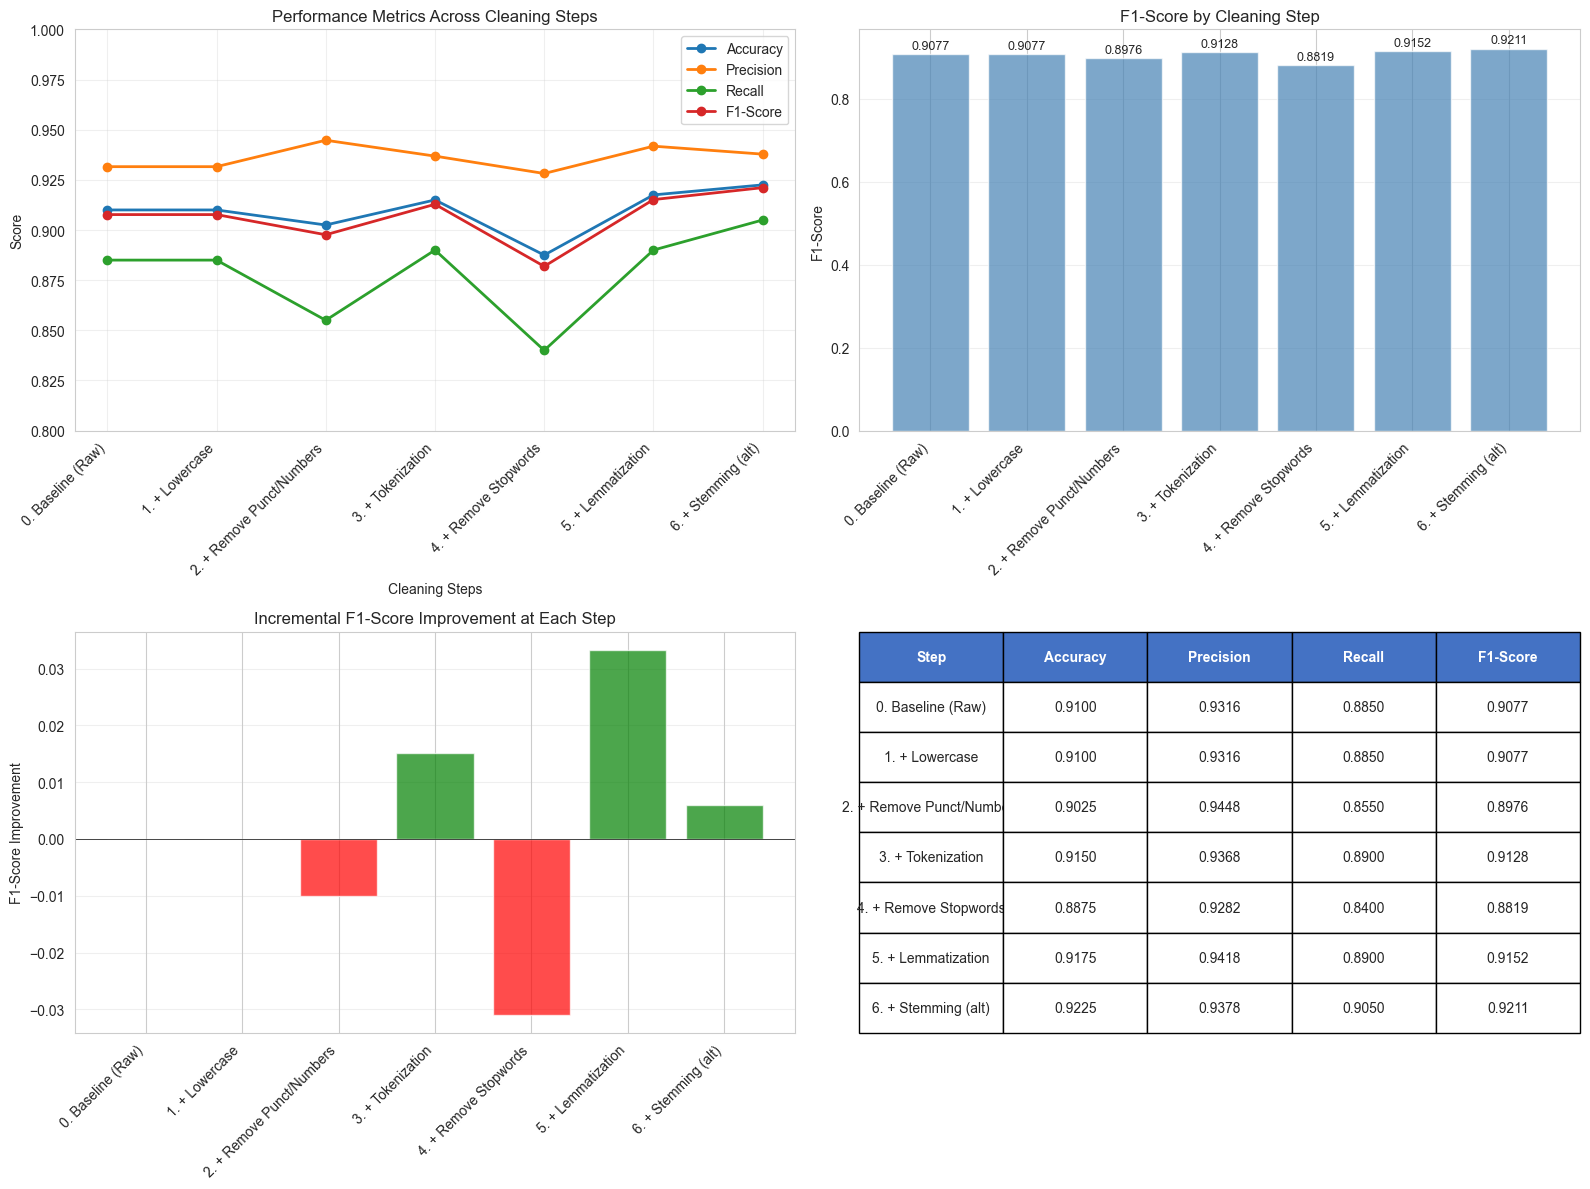

In [129]:
# Visualization - Performance Across Cleaning Steps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All Metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for metric in metrics_to_plot:
    axes[0, 0].plot(results_df['Step'], results_df[metric], marker='o', label=metric, linewidth=2)
axes[0, 0].set_xlabel('Cleaning Steps')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Metrics Across Cleaning Steps')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0.8, 1.0])
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: F1-Score Focus
axes[0, 1].bar(range(len(results_df)), results_df['F1-Score'], color='steelblue', alpha=0.7)
axes[0, 1].set_xticks(range(len(results_df)))
axes[0, 1].set_xticklabels(results_df['Step'], rotation=45, ha='right')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score by Cleaning Step')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['F1-Score']):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Incremental Improvements
improvements = [0] + [results_df.iloc[i]['F1-Score'] - results_df.iloc[i-1]['F1-Score'] 
                      for i in range(1, len(results_df))]
colors = ['green' if x >= 0 else 'red' for x in improvements]
axes[1, 0].bar(range(len(improvements)), improvements, color=colors, alpha=0.7)
axes[1, 0].set_xticks(range(len(results_df)))
axes[1, 0].set_xticklabels(results_df['Step'], rotation=45, ha='right')
axes[1, 0].set_ylabel('F1-Score Improvement')
axes[1, 0].set_title('Incremental F1-Score Improvement at Each Step')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Comparison Table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for i, row in results_df.iterrows():
    table_data.append([
        row['Step'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1-Score']:.4f}"
    ])
table = axes[1, 1].table(cellText=table_data,
                         colLabels=['Step', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
# Color header
for i in range(5):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.tight_layout()
plt.show()

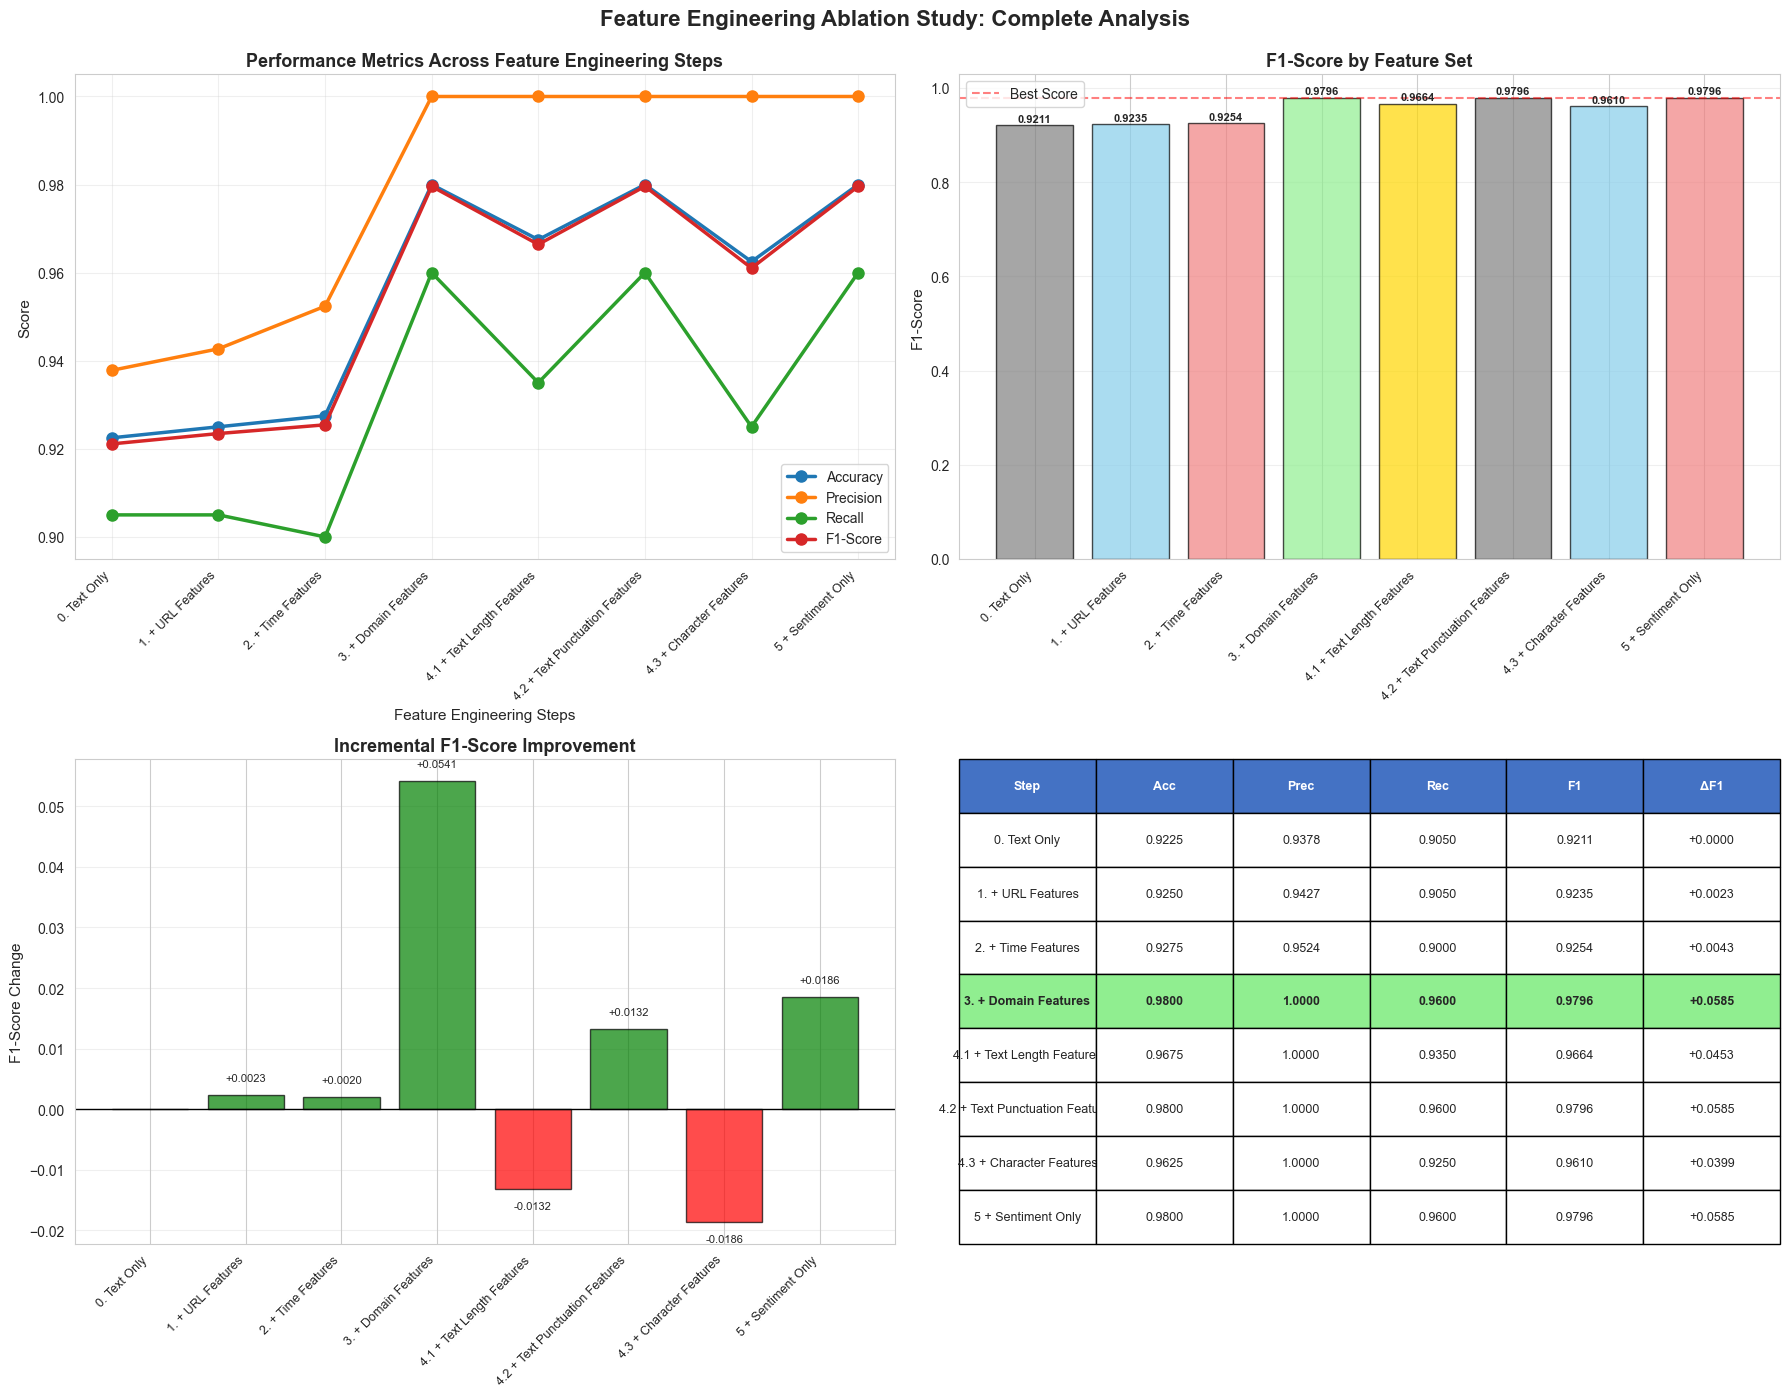

In [130]:
# ============================================================================
# VISUALIZATION - FEATURE ENGINEERING RESULTS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: All Metrics Progression
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_positions = range(len(results_fe_df))
for metric in metrics_to_plot:
    axes[0, 0].plot(x_positions, results_fe_df[metric], marker='o', 
                    label=metric, linewidth=2.5, markersize=8)
axes[0, 0].set_xlabel('Feature Engineering Steps', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Performance Metrics Across Feature Engineering Steps', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(x_positions)
axes[0, 0].set_xticklabels(results_fe_df['Step'], rotation=45, ha='right', fontsize=9)

# Plot 2: F1-Score Comparison
colors_f1 = ['gray', 'skyblue', 'lightcoral', 'lightgreen', 'gold']
axes[0, 1].bar(x_positions, results_fe_df['F1-Score'], color=colors_f1, 
               alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(x_positions)
axes[0, 1].set_xticklabels(results_fe_df['Step'], rotation=45, ha='right', fontsize=9)
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('F1-Score by Feature Set', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=results_fe_df['F1-Score'].max(), color='red', 
                   linestyle='--', linewidth=1.5, alpha=0.5, label='Best Score')
axes[0, 1].legend()
for i, v in enumerate(results_fe_df['F1-Score']):
    axes[0, 1].text(i, v + 0.003, f'{v:.4f}', ha='center', 
                    va='bottom', fontsize=8, fontweight='bold')

# Plot 3: Incremental Improvements
improvements = [0] + [results_fe_df.iloc[i]['F1-Score'] - results_fe_df.iloc[i-1]['F1-Score'] 
                      for i in range(1, len(results_fe_df))]
colors = ['green' if x >= 0 else 'red' for x in improvements]
bars = axes[1, 0].bar(x_positions, improvements, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(x_positions)
axes[1, 0].set_xticklabels(results_fe_df['Step'], rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('F1-Score Change', fontsize=11)
axes[1, 0].set_title('Incremental F1-Score Improvement', fontsize=13, fontweight='bold')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, improvements)):
    if val != 0:
        axes[1, 0].text(i, val + (0.002 if val > 0 else -0.002), f'{val:+.4f}', 
                       ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

# Plot 4: Results Table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for i, row in results_fe_df.iterrows():
    improvement = row['F1-Score'] - results_fe_df.iloc[0]['F1-Score']
    table_data.append([
        row['Step'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1-Score']:.4f}",
        f"{improvement:+.4f}"
    ])
table = axes[1, 1].table(cellText=table_data,
                         colLabels=['Step', 'Acc', 'Prec', 'Rec', 'F1', 'ΔF1'],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color header
for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best row
best_row_idx = results_fe_df['F1-Score'].idxmax() + 1
for i in range(6):
    table[(best_row_idx, i)].set_facecolor('#90EE90')
    table[(best_row_idx, i)].set_text_props(weight='bold')

plt.suptitle('Feature Engineering Ablation Study: Complete Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS
TOP 20 SPAM INDICATORS (Logistic Regression):
  your                          :  0.6355
  replica                       :  0.5274
  watch                         :  0.4611
  com                           :  0.4559
  cnn                           :  0.4397
  usaa                          :  0.4260
  watches                       :  0.4251
  our                           :  0.4012
  you                           :  0.3627
  love                          :  0.3577
  cnn com                       :  0.3372
  size                          :  0.3289
  men                           :  0.3049
  health                        :  0.3020
  life                          :  0.2856
  replica watches               :  0.2827
  transfer                      :  0.2786
  safe                          :  0.2644
  paris                         :  0.2556
  000                           :  0.2536

TOP 20 LEGIT INDICATORS (Logistic Regression):
  org                           : -0.7

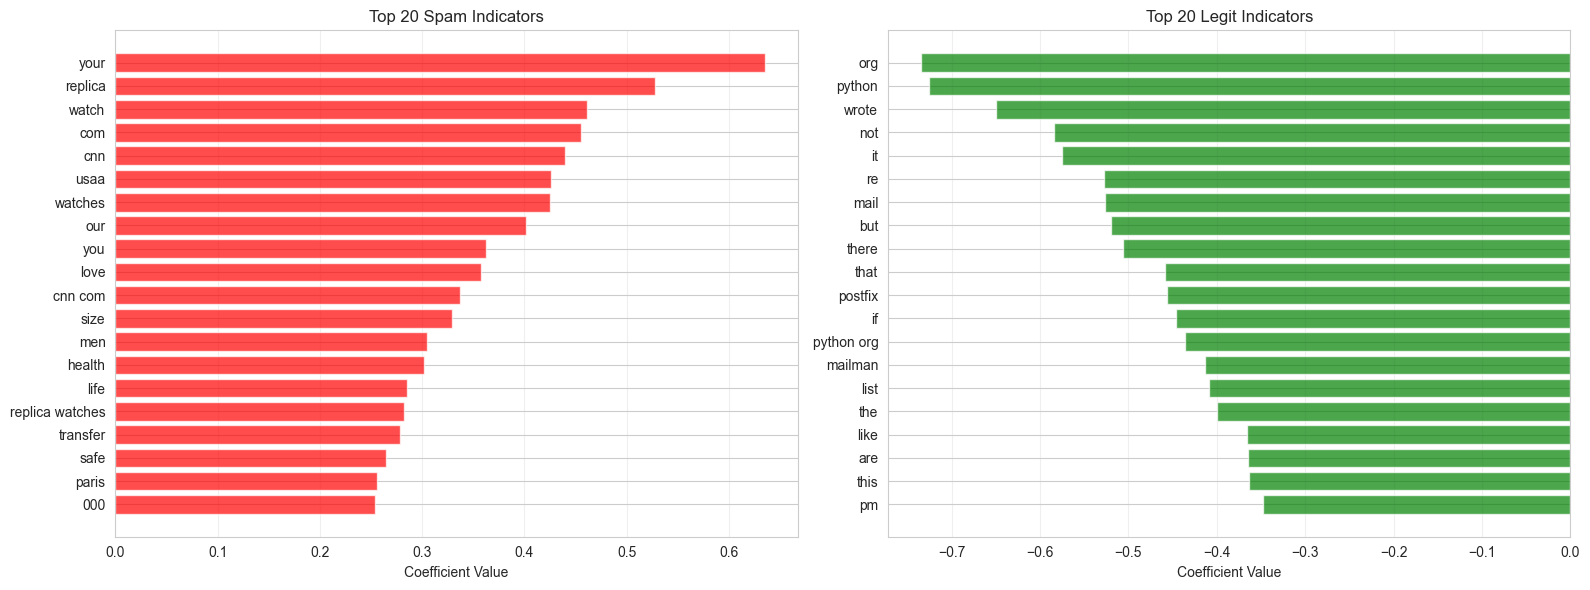

In [131]:
# Feature Importance Analysis (Top words for spam detection)

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# For Logistic Regression, get top features by coefficient magnitude
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
lr_coef = lr_model.coef_[0]

# Top spam indicators (positive coefficients)
top_spam_indices = np.argsort(lr_coef)[-20:][::-1]
top_spam_features = feature_names[top_spam_indices]
top_spam_coefs = lr_coef[top_spam_indices]

# Top legit indicators (negative coefficients)
top_legit_indices = np.argsort(lr_coef)[:20]
top_legit_features = feature_names[top_legit_indices]
top_legit_coefs = lr_coef[top_legit_indices]

print("TOP 20 SPAM INDICATORS (Logistic Regression):")
for feature, coef in zip(top_spam_features, top_spam_coefs):
    print(f"  {feature:30s}: {coef:7.4f}")
print()

print("TOP 20 LEGIT INDICATORS (Logistic Regression):")
for feature, coef in zip(top_legit_features, top_legit_coefs):
    print(f"  {feature:30s}: {coef:7.4f}")
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Spam indicators
axes[0].barh(range(len(top_spam_features)), top_spam_coefs, color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_spam_features)))
axes[0].set_yticklabels(top_spam_features)
axes[0].invert_yaxis()
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Top 20 Spam Indicators')
axes[0].grid(axis='x', alpha=0.3)

# Legit indicators
axes[1].barh(range(len(top_legit_features)), top_legit_coefs, color='green', alpha=0.7)
axes[1].set_yticks(range(len(top_legit_features)))
axes[1].set_yticklabels(top_legit_features)
axes[1].invert_yaxis()
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Top 20 Legit Indicators')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()